In [1]:
import sys
sys.path.append("../")

import jax
import jax.numpy as np
import flax
import flax.linen as nn
from flax.training.train_state import TrainState
from functools import partial
import optax
from tqdm import trange

from models.diffusion import VariationalDiffusionModel
from models.transformer import Transformer

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

%load_ext autoreload
%autoreload 2

2024-03-11 15:23:03.240640: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-11 15:23:03.250116: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-11 15:23:06.477976: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


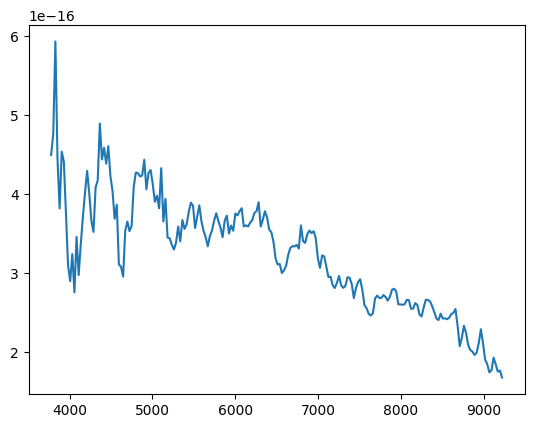

In [3]:
import pandas as pd

spectra = pd.read_csv("../data/ZTFBTS_spectra/ZTF18aaqpeoq.csv", header=None)

# Get first and second columns
wavelength = spectra[0]
flux = spectra[1]

# Plot
import matplotlib.pyplot as plt
plt.plot(wavelength, flux)

In [4]:
# Get all the CSV files in the directory
import os
import glob
from tqdm import tqdm

files = glob.glob("../data/ZTFBTS_spectra/*.csv")  # [:4000]

# Loop over spectra, pad to max length, and add to training
max_length = 1000
wavelengths = []
fluxes = []
masks = []

len_list = []

for file in tqdm(files):
    # Read in the CSV
    spectra_pd = pd.read_csv(file, header=None)

    len_list.append(len(spectra_pd))
    
    if len(spectra_pd) > max_length:
        print(f"Skipping {file} because it's too long with length {len(spectra_pd)}")
        continue

    wavelength = spectra_pd[0].values
    flux = spectra_pd[1].values
    
    # Pad the flux, wavelength, and mask
    flux = np.pad(flux, (0, max_length - len(flux)))
    wavelength = np.pad(wavelength, (0, max_length - len(wavelength)))
    
    # Mask should be zero where the padding is
    mask = np.ones(max_length)
    mask = mask.at[len(spectra_pd):].set(0)

    # Append to the list
    fluxes.append(flux)
    wavelengths.append(wavelength)
    masks.append(mask)

# Stack the fluxes, spectra, and masks  
fluxes = np.stack(fluxes)
wavelengths = np.stack(wavelengths)
masks = np.stack(masks)
    
# Convert masks to bool
masks = masks.astype(bool)

# Normalize the fluxes and wavelengths
fluxes_mean = np.mean(fluxes)
fluxes_std = np.std(fluxes)

wavelengths_mean = np.mean(wavelengths)
wavelengths_std = np.std(wavelengths)

fluxes = (fluxes - fluxes_mean) / fluxes_std
wavelengths = (wavelengths - wavelengths_mean) / wavelengths_std

# Shapes
print(fluxes.shape, wavelengths.shape, masks.shape)

  0%|          | 1/5094 [00:03<5:26:00,  3.84s/it]

Skipping ../data/ZTFBTS_spectra/ZTF19aatgrxl.csv because it's too long with length 3197


  0%|          | 10/5094 [00:04<25:35,  3.31it/s] 

Skipping ../data/ZTFBTS_spectra/ZTF20abywoaa.csv because it's too long with length 5125
Skipping ../data/ZTFBTS_spectra/ZTF19aakjcxs.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF23aaeinqq.csv because it's too long with length 5125


  0%|          | 17/5094 [00:04<13:57,  6.06it/s]

Skipping ../data/ZTFBTS_spectra/ZTF21abmspkq.csv because it's too long with length 1538
Skipping ../data/ZTFBTS_spectra/ZTF21abhqqfa.csv because it's too long with length 1628
Skipping ../data/ZTFBTS_spectra/ZTF21abpmlxu.csv because it's too long with length 1800
Skipping ../data/ZTFBTS_spectra/ZTF21abhzboh.csv because it's too long with length 2711
Skipping ../data/ZTFBTS_spectra/ZTF19acdabep.csv because it's too long with length 4263
Skipping ../data/ZTFBTS_spectra/ZTF19aaoaaap.csv because it's too long with length 4303
Skipping ../data/ZTFBTS_spectra/ZTF22aajryew.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF23aaemtdr.csv because it's too long with length 2843


  1%|          | 40/5094 [00:04<04:51, 17.36it/s]

Skipping ../data/ZTFBTS_spectra/ZTF22aasdtcq.csv because it's too long with length 5095
Skipping ../data/ZTFBTS_spectra/ZTF18acaezsx.csv because it's too long with length 5082
Skipping ../data/ZTFBTS_spectra/ZTF20acwqqjs.csv because it's too long with length 1011


  1%|          | 60/5094 [00:05<03:33, 23.62it/s]

Skipping ../data/ZTFBTS_spectra/ZTF20acpmgdz.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF22abdondo.csv because it's too long with length 3854
Skipping ../data/ZTFBTS_spectra/ZTF22abyskhb.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF23aadtrzd.csv because it's too long with length 5117
Skipping ../data/ZTFBTS_spectra/ZTF23aasovdv.csv because it's too long with length 7094
Skipping ../data/ZTFBTS_spectra/ZTF21aatvcdl.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF22aaeviey.csv because it's too long with length 2842
Skipping ../data/ZTFBTS_spectra/ZTF22abfuyqr.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF22aahedwz.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF19aboudfp.csv because it's too long with length 1015


  2%|▏         | 102/5094 [00:05<01:34, 53.06it/s]

Skipping ../data/ZTFBTS_spectra/ZTF23aabasoe.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF20abgtvhl.csv because it's too long with length 4329
Skipping ../data/ZTFBTS_spectra/ZTF23aarqyio.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF22abegjkl.csv because it's too long with length 1664
Skipping ../data/ZTFBTS_spectra/ZTF23aakyoji.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF20acklcyp.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF19aafmyow.csv because it's too long with length 3303


  2%|▏         | 119/5094 [00:05<01:27, 57.11it/s]

Skipping ../data/ZTFBTS_spectra/ZTF22abatqod.csv because it's too long with length 1773
Skipping ../data/ZTFBTS_spectra/ZTF22abmygmc.csv because it's too long with length 1019
Skipping ../data/ZTFBTS_spectra/ZTF19abqykei.csv because it's too long with length 1015


  3%|▎         | 128/5094 [00:06<01:56, 42.66it/s]

Skipping ../data/ZTFBTS_spectra/ZTF23aajmpsa.csv because it's too long with length 2413


  3%|▎         | 135/5094 [00:06<02:04, 39.83it/s]

Skipping ../data/ZTFBTS_spectra/ZTF23abgzrmz.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF21abuguyw.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF23abbtkrv.csv because it's too long with length 5228
Skipping ../data/ZTFBTS_spectra/ZTF23aascppn.csv because it's too long with length 1803
Skipping ../data/ZTFBTS_spectra/ZTF20aclxbwk.csv because it's too long with length 1015


  3%|▎         | 153/5094 [00:06<01:43, 47.56it/s]

Skipping ../data/ZTFBTS_spectra/ZTF21acfmxeu.csv because it's too long with length 7094
Skipping ../data/ZTFBTS_spectra/ZTF19aafmfxg.csv because it's too long with length 4065
Skipping ../data/ZTFBTS_spectra/ZTF18aaermez.csv because it's too long with length 4395
Skipping ../data/ZTFBTS_spectra/ZTF22aasojye.csv because it's too long with length 5105
Skipping ../data/ZTFBTS_spectra/ZTF20aabconi.csv because it's too long with length 1531
Skipping ../data/ZTFBTS_spectra/ZTF19acqypso.csv because it's too long with length 3530
Skipping ../data/ZTFBTS_spectra/ZTF22aaxfqka.csv because it's too long with length 1900


  5%|▍         | 234/5094 [00:07<00:40, 121.16it/s]

Skipping ../data/ZTFBTS_spectra/ZTF23aailjjs.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF20abonvte.csv because it's too long with length 4329
Skipping ../data/ZTFBTS_spectra/ZTF22abiyjlx.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF22abbtjlb.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF19aatlmbo.csv because it's too long with length 4827
Skipping ../data/ZTFBTS_spectra/ZTF22abhsxph.csv because it's too long with length 5142
Skipping ../data/ZTFBTS_spectra/ZTF19ablesob.csv because it's too long with length 4329
Skipping ../data/ZTFBTS_spectra/ZTF19abzzuyl.csv because it's too long with length 4526
Skipping ../data/ZTFBTS_spectra/ZTF20aclkuqh.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF23abolkiw.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF23aasopeh.csv because it's too long with length 2842
Skipping ../data/ZTFBTS_spectra/

  6%|▌         | 317/5094 [00:07<00:29, 164.15it/s]

Skipping ../data/ZTFBTS_spectra/ZTF18aaxnqjb.csv because it's too long with length 3608
Skipping ../data/ZTFBTS_spectra/ZTF22aacwsjl.csv because it's too long with length 5083
Skipping ../data/ZTFBTS_spectra/ZTF21acgxzha.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF19aakljys.csv because it's too long with length 1023
Skipping ../data/ZTFBTS_spectra/ZTF19aahjhoy.csv because it's too long with length 4395
Skipping ../data/ZTFBTS_spectra/ZTF22aasvuof.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF20acajvrj.csv because it's too long with length 2860
Skipping ../data/ZTFBTS_spectra/ZTF20acqfssi.csv because it's too long with length 3332
Skipping ../data/ZTFBTS_spectra/ZTF21abqgrqd.csv because it's too long with length 5086
Skipping ../data/ZTFBTS_spectra/ZTF20abwftit.csv because it's too long with length 5128
Skipping ../data/ZTFBTS_spectra/ZTF21aciwixf.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/

  7%|▋         | 349/5094 [00:07<00:24, 195.92it/s]

Skipping ../data/ZTFBTS_spectra/ZTF20abrcnbr.csv because it's too long with length 5125
Skipping ../data/ZTFBTS_spectra/ZTF23aavzvmp.csv because it's too long with length 2675
Skipping ../data/ZTFBTS_spectra/ZTF21aapkhsc.csv because it's too long with length 3197
Skipping ../data/ZTFBTS_spectra/ZTF18abmjvuf.csv because it's too long with length 5901
Skipping ../data/ZTFBTS_spectra/ZTF19aamvmer.csv because it's too long with length 3008
Skipping ../data/ZTFBTS_spectra/ZTF21aamkxbl.csv because it's too long with length 2842
Skipping ../data/ZTFBTS_spectra/ZTF22abfskre.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF22abntdem.csv because it's too long with length 1806
Skipping ../data/ZTFBTS_spectra/ZTF23abktfjr.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF21aajgdpo.csv because it's too long with length 5107
Skipping ../data/ZTFBTS_spectra/ZTF21acgxypn.csv because it's too long with length 4955
Skipping ../data/ZTFBTS_spectra/

  8%|▊         | 407/5094 [00:08<00:25, 180.27it/s]

Skipping ../data/ZTFBTS_spectra/ZTF20abywsut.csv because it's too long with length 1594
Skipping ../data/ZTFBTS_spectra/ZTF23aagkutf.csv because it's too long with length 1748
Skipping ../data/ZTFBTS_spectra/ZTF20acowddo.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF20aaeujsk.csv because it's too long with length 1831
Skipping ../data/ZTFBTS_spectra/ZTF18abkifng.csv because it's too long with length 5901
Skipping ../data/ZTFBTS_spectra/ZTF21aamobbh.csv because it's too long with length 2600
Skipping ../data/ZTFBTS_spectra/ZTF20aclkyhj.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF18acvwbos.csv because it's too long with length 4329
Skipping ../data/ZTFBTS_spectra/ZTF20abccixp.csv because it's too long with length 1621
Skipping ../data/ZTFBTS_spectra/ZTF20abqgbum.csv because it's too long with length 1593
Skipping ../data/ZTFBTS_spectra/ZTF23aarrwwl.csv because it's too long with length 1704
Skipping ../data/ZTFBTS_spectra/

  9%|▉         | 471/5094 [00:08<00:20, 229.52it/s]

Skipping ../data/ZTFBTS_spectra/ZTF19acewotx.csv because it's too long with length 2225
Skipping ../data/ZTFBTS_spectra/ZTF22aaijrci.csv because it's too long with length 5147
Skipping ../data/ZTFBTS_spectra/ZTF20acpjqxp.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF20acvebcu.csv because it's too long with length 2842
Skipping ../data/ZTFBTS_spectra/ZTF23abnrtcb.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF21aaoqcnh.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF21aaezixn.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF20acqelhh.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF20actveqm.csv because it's too long with length 2030
Skipping ../data/ZTFBTS_spectra/ZTF19acfxbki.csv because it's too long with length 4263
Skipping ../data/ZTFBTS_spectra/ZTF22abfxwub.csv because it's too long with length 1741
Skipping ../data/ZTFBTS_spectra/

 10%|▉         | 504/5094 [00:08<00:18, 254.22it/s]

Skipping ../data/ZTFBTS_spectra/ZTF18aavqdyq.csv because it's too long with length 4067
Skipping ../data/ZTFBTS_spectra/ZTF22abizuah.csv because it's too long with length 5386
Skipping ../data/ZTFBTS_spectra/ZTF23abluzif.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF21abuuzrk.csv because it's too long with length 5137
Skipping ../data/ZTFBTS_spectra/ZTF23abochfb.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF22aahftli.csv because it's too long with length 3855
Skipping ../data/ZTFBTS_spectra/ZTF21abubxmc.csv because it's too long with length 1800
Skipping ../data/ZTFBTS_spectra/ZTF21achlxxo.csv because it's too long with length 2711
Skipping ../data/ZTFBTS_spectra/ZTF18aacnlxz.csv because it's too long with length 2712
Skipping ../data/ZTFBTS_spectra/ZTF20abxidyb.csv because it's too long with length 5465
Skipping ../data/ZTFBTS_spectra/ZTF19abiszzn.csv because it's too long with length 4329
Skipping ../data/ZTFBTS_spectra/

 11%|█         | 566/5094 [00:08<00:22, 203.86it/s]

Skipping ../data/ZTFBTS_spectra/ZTF20acorjop.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF21aaqldsj.csv because it's too long with length 1765
Skipping ../data/ZTFBTS_spectra/ZTF23abjuygh.csv because it's too long with length 1861
Skipping ../data/ZTFBTS_spectra/ZTF23aaxadel.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF19abmzmom.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF21acgudgo.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF21abpxquj.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF23abavqdt.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF23abaxxrd.csv because it's too long with length 7093
Skipping ../data/ZTFBTS_spectra/ZTF21abqfttg.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF20ablklei.csv because it's too long with length 8319
Skipping ../data/ZTFBTS_spectra/

 12%|█▏        | 633/5094 [00:09<00:17, 255.65it/s]

Skipping ../data/ZTFBTS_spectra/ZTF22aazuotw.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF21abccaue.csv because it's too long with length 4691
Skipping ../data/ZTFBTS_spectra/ZTF20acpqbfu.csv because it's too long with length 5135
Skipping ../data/ZTFBTS_spectra/ZTF22aasyada.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF21aawckpe.csv because it's too long with length 1399
Skipping ../data/ZTFBTS_spectra/ZTF21aclypvs.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF19abxekxi.csv because it's too long with length 4303
Skipping ../data/ZTFBTS_spectra/ZTF20abvvnqh.csv because it's too long with length 2928
Skipping ../data/ZTFBTS_spectra/ZTF20aabqiav.csv because it's too long with length 4329
Skipping ../data/ZTFBTS_spectra/ZTF23aansrmz.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF22absibqa.csv because it's too long with length 1741
Skipping ../data/ZTFBTS_spectra/

 14%|█▎        | 696/5094 [00:09<00:20, 210.13it/s]

Skipping ../data/ZTFBTS_spectra/ZTF18aaisqmw.csv because it's too long with length 2711
Skipping ../data/ZTFBTS_spectra/ZTF21aaipypa.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF21abrgbex.csv because it's too long with length 5124
Skipping ../data/ZTFBTS_spectra/ZTF21aadktwq.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF21aapxogj.csv because it's too long with length 4976
Skipping ../data/ZTFBTS_spectra/ZTF22abpxxil.csv because it's too long with length 5125
Skipping ../data/ZTFBTS_spectra/ZTF21aanplys.csv because it's too long with length 2842
Skipping ../data/ZTFBTS_spectra/ZTF23aanpuwv.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF20abixkhh.csv because it's too long with length 1594
Skipping ../data/ZTFBTS_spectra/ZTF19aavnwyt.csv because it's too long with length 5901
Skipping ../data/ZTFBTS_spectra/ZTF23abomtjc.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/

 15%|█▌        | 767/5094 [00:09<00:16, 267.72it/s]

Skipping ../data/ZTFBTS_spectra/ZTF21abdmevk.csv because it's too long with length 1871
Skipping ../data/ZTFBTS_spectra/ZTF20abyzoof.csv because it's too long with length 4781
Skipping ../data/ZTFBTS_spectra/ZTF21abrxoir.csv because it's too long with length 2842
Skipping ../data/ZTFBTS_spectra/ZTF23aaqujvz.csv because it's too long with length 5132
Skipping ../data/ZTFBTS_spectra/ZTF19abzgdfu.csv because it's too long with length 3550
Skipping ../data/ZTFBTS_spectra/ZTF18abeyqpr.csv because it's too long with length 1729
Skipping ../data/ZTFBTS_spectra/ZTF23abiearq.csv because it's too long with length 1815
Skipping ../data/ZTFBTS_spectra/ZTF19aayogzn.csv because it's too long with length 4329
Skipping ../data/ZTFBTS_spectra/ZTF23aaaboss.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF21aarqkes.csv because it's too long with length 2400
Skipping ../data/ZTFBTS_spectra/ZTF21abuetqc.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/

 16%|█▋        | 834/5094 [00:10<00:24, 174.42it/s]

Skipping ../data/ZTFBTS_spectra/ZTF19abiqfxi.csv because it's too long with length 3551
Skipping ../data/ZTFBTS_spectra/ZTF21abcwsho.csv because it's too long with length 1538
Skipping ../data/ZTFBTS_spectra/ZTF22abghrui.csv because it's too long with length 1712
Skipping ../data/ZTFBTS_spectra/ZTF20aclkvjy.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF22abteujl.csv because it's too long with length 1861
Skipping ../data/ZTFBTS_spectra/ZTF21aaabwem.csv because it's too long with length 5119
Skipping ../data/ZTFBTS_spectra/ZTF22abawyul.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF21abtuutw.csv because it's too long with length 2843
Skipping ../data/ZTFBTS_spectra/ZTF21acdmwae.csv because it's too long with length 2300
Skipping ../data/ZTFBTS_spectra/ZTF20acpcuwx.csv because it's too long with length 2568
Skipping ../data/ZTFBTS_spectra/ZTF18abmxahs.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/

 17%|█▋        | 863/5094 [00:10<00:21, 195.24it/s]

Skipping ../data/ZTFBTS_spectra/ZTF19abdoior.csv because it's too long with length 4329
Skipping ../data/ZTFBTS_spectra/ZTF23abhailb.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF21abqgbau.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF20acphbem.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF20adadrhw.csv because it's too long with length 5785
Skipping ../data/ZTFBTS_spectra/ZTF18aavdwmh.csv because it's too long with length 5117
Skipping ../data/ZTFBTS_spectra/ZTF20acpwjus.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF21aacufip.csv because it's too long with length 4764
Skipping ../data/ZTFBTS_spectra/ZTF19abqirpa.csv because it's too long with length 1766
Skipping ../data/ZTFBTS_spectra/ZTF18adbyxua.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF23aaabgzf.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/

 17%|█▋        | 891/5094 [00:10<00:27, 154.18it/s]

Skipping ../data/ZTFBTS_spectra/ZTF19abtsrup.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF19aadolpe.csv because it's too long with length 4329
Skipping ../data/ZTFBTS_spectra/ZTF21aaxjvyl.csv because it's too long with length 4975
Skipping ../data/ZTFBTS_spectra/ZTF19abgpgyp.csv because it's too long with length 3733


 19%|█▊        | 945/5094 [00:10<00:26, 155.54it/s]

Skipping ../data/ZTFBTS_spectra/ZTF18abfhryc.csv because it's too long with length 3734
Skipping ../data/ZTFBTS_spectra/ZTF21aaeoxfd.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF23aaejwfe.csv because it's too long with length 1861
Skipping ../data/ZTFBTS_spectra/ZTF19aavouyw.csv because it's too long with length 5126
Skipping ../data/ZTFBTS_spectra/ZTF18aarcypa.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF22abngjlt.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF23abhzfww.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF20abywydb.csv because it's too long with length 5126
Skipping ../data/ZTFBTS_spectra/ZTF22aaxzzoc.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF18aaxeoqk.csv because it's too long with length 1885
Skipping ../data/ZTFBTS_spectra/ZTF19abfpupe.csv because it's too long with length 4329
Skipping ../data/ZTFBTS_spectra/

 20%|█▉        | 1006/5094 [00:11<00:19, 208.47it/s]

Skipping ../data/ZTFBTS_spectra/ZTF20abzjcdg.csv because it's too long with length 5124
Skipping ../data/ZTFBTS_spectra/ZTF21abjhiqp.csv because it's too long with length 4045
Skipping ../data/ZTFBTS_spectra/ZTF19aadpqnb.csv because it's too long with length 3197
Skipping ../data/ZTFBTS_spectra/ZTF21aaogifb.csv because it's too long with length 2198
Skipping ../data/ZTFBTS_spectra/ZTF21acfccil.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF23aapbrrq.csv because it's too long with length 3854
Skipping ../data/ZTFBTS_spectra/ZTF18aapictz.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF23abcegjv.csv because it's too long with length 7091
Skipping ../data/ZTFBTS_spectra/ZTF21abmqpja.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF21abzciqh.csv because it's too long with length 5111
Skipping ../data/ZTFBTS_spectra/ZTF23abhshea.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/

 20%|██        | 1036/5094 [00:11<00:17, 227.82it/s]

Skipping ../data/ZTFBTS_spectra/ZTF23aarxtku.csv because it's too long with length 2310
Skipping ../data/ZTFBTS_spectra/ZTF23aaepuao.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF21abhuoyz.csv because it's too long with length 2711
Skipping ../data/ZTFBTS_spectra/ZTF20aadxrvb.csv because it's too long with length 1798
Skipping ../data/ZTFBTS_spectra/ZTF20aattyuz.csv because it's too long with length 4723
Skipping ../data/ZTFBTS_spectra/ZTF23aazpvbm.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF20aaurjbj.csv because it's too long with length 2531
Skipping ../data/ZTFBTS_spectra/ZTF18achcpwu.csv because it's too long with length 4329
Skipping ../data/ZTFBTS_spectra/ZTF20abbplei.csv because it's too long with length 2842
Skipping ../data/ZTFBTS_spectra/ZTF20aafmdzj.csv because it's too long with length 4299
Skipping ../data/ZTFBTS_spectra/ZTF22abembaz.csv because it's too long with length 7094
Skipping ../data/ZTFBTS_spectra/

 21%|██        | 1064/5094 [00:11<00:24, 161.71it/s]

Skipping ../data/ZTFBTS_spectra/ZTF21abujgmr.csv because it's too long with length 6021
Skipping ../data/ZTFBTS_spectra/ZTF19acetzrc.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF21aavotzn.csv because it's too long with length 1764
Skipping ../data/ZTFBTS_spectra/ZTF23abmewfr.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF23abapoiv.csv because it's too long with length 1689
Skipping ../data/ZTFBTS_spectra/ZTF19aamhqej.csv because it's too long with length 2401
Skipping ../data/ZTFBTS_spectra/ZTF21abahyyj.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF18aayidfz.csv because it's too long with length 5901
Skipping ../data/ZTFBTS_spectra/ZTF21abqymzg.csv because it's too long with length 1900


 22%|██▏       | 1109/5094 [00:11<00:27, 145.25it/s]

Skipping ../data/ZTFBTS_spectra/ZTF20abcsjtx.csv because it's too long with length 4038
Skipping ../data/ZTFBTS_spectra/ZTF23aavzgjg.csv because it's too long with length 1537
Skipping ../data/ZTFBTS_spectra/ZTF19acbmxky.csv because it's too long with length 4263
Skipping ../data/ZTFBTS_spectra/ZTF19aaairqh.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF21abcpsjy.csv because it's too long with length 1600
Skipping ../data/ZTFBTS_spectra/ZTF21aadkhte.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF22aauurbv.csv because it's too long with length 5145
Skipping ../data/ZTFBTS_spectra/ZTF18aazabmh.csv because it's too long with length 5901
Skipping ../data/ZTFBTS_spectra/ZTF21aalkltz.csv because it's too long with length 5122
Skipping ../data/ZTFBTS_spectra/ZTF19abbthwy.csv because it's too long with length 4591
Skipping ../data/ZTFBTS_spectra/ZTF22abbausm.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/

 22%|██▏       | 1140/5094 [00:12<00:22, 176.05it/s]

Skipping ../data/ZTFBTS_spectra/ZTF19abyzuos.csv because it's too long with length 2196
Skipping ../data/ZTFBTS_spectra/ZTF21abbqeea.csv because it's too long with length 5892
Skipping ../data/ZTFBTS_spectra/ZTF20acpjfln.csv because it's too long with length 5901
Skipping ../data/ZTFBTS_spectra/ZTF18aaytovs.csv because it's too long with length 4657
Skipping ../data/ZTFBTS_spectra/ZTF19abzhfjj.csv because it's too long with length 4303
Skipping ../data/ZTFBTS_spectra/ZTF22absphuu.csv because it's too long with length 5131


 23%|██▎       | 1196/5094 [00:12<00:23, 168.42it/s]

Skipping ../data/ZTFBTS_spectra/ZTF21aapejbx.csv because it's too long with length 1800
Skipping ../data/ZTFBTS_spectra/ZTF22aajsdkt.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF21abovblm.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF20aansmsj.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF19abxmvcq.csv because it's too long with length 3855
Skipping ../data/ZTFBTS_spectra/ZTF22aapargp.csv because it's too long with length 1800
Skipping ../data/ZTFBTS_spectra/ZTF21aavhlok.csv because it's too long with length 1507
Skipping ../data/ZTFBTS_spectra/ZTF20acopmey.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF22abtspsw.csv because it's too long with length 2300
Skipping ../data/ZTFBTS_spectra/ZTF18aaszvfn.csv because it's too long with length 1399
Skipping ../data/ZTFBTS_spectra/ZTF21abxmxut.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/

 25%|██▍       | 1250/5094 [00:12<00:19, 198.84it/s]

Skipping ../data/ZTFBTS_spectra/ZTF19acukucu.csv because it's too long with length 1861
Skipping ../data/ZTFBTS_spectra/ZTF20aamiwbp.csv because it's too long with length 4170
Skipping ../data/ZTFBTS_spectra/ZTF20acviwgj.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF20abzgegm.csv because it's too long with length 5104
Skipping ../data/ZTFBTS_spectra/ZTF21aagsihi.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF19aauhhjy.csv because it's too long with length 4304
Skipping ../data/ZTFBTS_spectra/ZTF20actekrw.csv because it's too long with length 2030
Skipping ../data/ZTFBTS_spectra/ZTF19abqrrto.csv because it's too long with length 4329
Skipping ../data/ZTFBTS_spectra/ZTF19acchaza.csv because it's too long with length 4263
Skipping ../data/ZTFBTS_spectra/ZTF19achetvw.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF21aaossxf.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/

 26%|██▌       | 1309/5094 [00:12<00:15, 238.22it/s]

Skipping ../data/ZTFBTS_spectra/ZTF20aaiawlj.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF20abaunmw.csv because it's too long with length 3733
Skipping ../data/ZTFBTS_spectra/ZTF22aajakms.csv because it's too long with length 5143
Skipping ../data/ZTFBTS_spectra/ZTF23aajkisd.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF20abawntz.csv because it's too long with length 4037
Skipping ../data/ZTFBTS_spectra/ZTF21acbuwgu.csv because it's too long with length 7092
Skipping ../data/ZTFBTS_spectra/ZTF19aaadwfi.csv because it's too long with length 4395
Skipping ../data/ZTFBTS_spectra/ZTF23abnpoqp.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF20acdnmpv.csv because it's too long with length 2600
Skipping ../data/ZTFBTS_spectra/ZTF22abfzarj.csv because it's too long with length 1833
Skipping ../data/ZTFBTS_spectra/ZTF22aavcvgd.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/

 26%|██▋       | 1340/5094 [00:12<00:14, 254.81it/s]

Skipping ../data/ZTFBTS_spectra/ZTF20aahbfmf.csv because it's too long with length 4657
Skipping ../data/ZTFBTS_spectra/ZTF23aaqnhjp.csv because it's too long with length 1867


 27%|██▋       | 1397/5094 [00:13<00:20, 184.41it/s]

Skipping ../data/ZTFBTS_spectra/ZTF23aawieyi.csv because it's too long with length 7094
Skipping ../data/ZTFBTS_spectra/ZTF21aaocrlm.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF20abqkmlp.csv because it's too long with length 5121
Skipping ../data/ZTFBTS_spectra/ZTF22aayubvt.csv because it's too long with length 5454
Skipping ../data/ZTFBTS_spectra/ZTF18adaadmh.csv because it's too long with length 4263
Skipping ../data/ZTFBTS_spectra/ZTF21aafkktu.csv because it's too long with length 1604
Skipping ../data/ZTFBTS_spectra/ZTF22aarbard.csv because it's too long with length 3561
Skipping ../data/ZTFBTS_spectra/ZTF19acxovyh.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF20aaosoct.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF21aapfdqw.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF22abdjqlm.csv because it's too long with length 3089
Skipping ../data/ZTFBTS_spectra/

 29%|██▊       | 1453/5094 [00:13<00:16, 222.40it/s]

Skipping ../data/ZTFBTS_spectra/ZTF21aauvmck.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF20abzbfct.csv because it's too long with length 3734
Skipping ../data/ZTFBTS_spectra/ZTF21aahdpvi.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF22aakpyqw.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF23abkaijq.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF23aahfxpr.csv because it's too long with length 1538
Skipping ../data/ZTFBTS_spectra/ZTF22abybbud.csv because it's too long with length 1791
Skipping ../data/ZTFBTS_spectra/ZTF21accibae.csv because it's too long with length 2712
Skipping ../data/ZTFBTS_spectra/ZTF18acszaiy.csv because it's too long with length 4394
Skipping ../data/ZTFBTS_spectra/ZTF19abpelgt.csv because it's too long with length 1571
Skipping ../data/ZTFBTS_spectra/ZTF20aaiaaoi.csv because it's too long with length 4170
Skipping ../data/ZTFBTS_spectra/

 30%|███       | 1534/5094 [00:14<00:18, 195.45it/s]

Skipping ../data/ZTFBTS_spectra/ZTF18aaqkqxi.csv because it's too long with length 4657
Skipping ../data/ZTFBTS_spectra/ZTF22ablxcrh.csv because it's too long with length 2979
Skipping ../data/ZTFBTS_spectra/ZTF21aaqafcf.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF23aaiwxqy.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF20abdnpdo.csv because it's too long with length 1685
Skipping ../data/ZTFBTS_spectra/ZTF21abmwzxt.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF23aaaplam.csv because it's too long with length 1754
Skipping ../data/ZTFBTS_spectra/ZTF19abatvzs.csv because it's too long with length 1748
Skipping ../data/ZTFBTS_spectra/ZTF21abidrcn.csv because it's too long with length 5132
Skipping ../data/ZTFBTS_spectra/ZTF19abiietd.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF18aaqjqqc.csv because it's too long with length 5099
Skipping ../data/ZTFBTS_spectra/

 31%|███▏      | 1594/5094 [00:14<00:14, 238.28it/s]

Skipping ../data/ZTFBTS_spectra/ZTF23aajbkan.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF21abatolf.csv because it's too long with length 5146
Skipping ../data/ZTFBTS_spectra/ZTF20acwcqnv.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF20actpavu.csv because it's too long with length 1023
Skipping ../data/ZTFBTS_spectra/ZTF21abotose.csv because it's too long with length 5131
Skipping ../data/ZTFBTS_spectra/ZTF20acwmpsj.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF20acgnenc.csv because it's too long with length 1739
Skipping ../data/ZTFBTS_spectra/ZTF22abfrbnl.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF18adbmrug.csv because it's too long with length 4460
Skipping ../data/ZTFBTS_spectra/ZTF21acozrga.csv because it's too long with length 2572
Skipping ../data/ZTFBTS_spectra/ZTF23abnpjlt.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/

 32%|███▏      | 1623/5094 [00:14<00:13, 250.84it/s]

Skipping ../data/ZTFBTS_spectra/ZTF19aaldqvh.csv because it's too long with length 4329
Skipping ../data/ZTFBTS_spectra/ZTF19acgjnfz.csv because it's too long with length 2215
Skipping ../data/ZTFBTS_spectra/ZTF23abbhuoa.csv because it's too long with length 7093
Skipping ../data/ZTFBTS_spectra/ZTF21acceboj.csv because it's too long with length 5136
Skipping ../data/ZTFBTS_spectra/ZTF18aczuooo.csv because it's too long with length 5901
Skipping ../data/ZTFBTS_spectra/ZTF23aadqhae.csv because it's too long with length 5047
Skipping ../data/ZTFBTS_spectra/ZTF20abcgkom.csv because it's too long with length 5818
Skipping ../data/ZTFBTS_spectra/ZTF19acrcxri.csv because it's too long with length 4301


 32%|███▏      | 1651/5094 [00:14<00:21, 162.40it/s]

Skipping ../data/ZTFBTS_spectra/ZTF20abrmmah.csv because it's too long with length 5110
Skipping ../data/ZTFBTS_spectra/ZTF21aapecxb.csv because it's too long with length 1900


 33%|███▎      | 1704/5094 [00:15<00:21, 157.60it/s]

Skipping ../data/ZTFBTS_spectra/ZTF21aciobmz.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF21abizpri.csv because it's too long with length 2606
Skipping ../data/ZTFBTS_spectra/ZTF20abtctgr.csv because it's too long with length 2042
Skipping ../data/ZTFBTS_spectra/ZTF19abnacvf.csv because it's too long with length 4329
Skipping ../data/ZTFBTS_spectra/ZTF20acpbboa.csv because it's too long with length 5785
Skipping ../data/ZTFBTS_spectra/ZTF21aapxtqg.csv because it's too long with length 2800
Skipping ../data/ZTFBTS_spectra/ZTF21abeeewf.csv because it's too long with length 1538
Skipping ../data/ZTFBTS_spectra/ZTF19acxxwrs.csv because it's too long with length 1861
Skipping ../data/ZTFBTS_spectra/ZTF20abyfmjr.csv because it's too long with length 5391
Skipping ../data/ZTFBTS_spectra/ZTF21aazieut.csv because it's too long with length 2843
Skipping ../data/ZTFBTS_spectra/ZTF23aakaqht.csv because it's too long with length 7093
Skipping ../data/ZTFBTS_spectra/

 34%|███▍      | 1726/5094 [00:15<00:26, 126.45it/s]

Skipping ../data/ZTFBTS_spectra/ZTF23abndrow.csv because it's too long with length 1800
Skipping ../data/ZTFBTS_spectra/ZTF19aagmpeq.csv because it's too long with length 4395
Skipping ../data/ZTFBTS_spectra/ZTF23abqcuvw.csv because it's too long with length 5229
Skipping ../data/ZTFBTS_spectra/ZTF21aarcldd.csv because it's too long with length 1538
Skipping ../data/ZTFBTS_spectra/ZTF23aahxdhe.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF23abjqxbe.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF19aayvylv.csv because it's too long with length 4329
Skipping ../data/ZTFBTS_spectra/ZTF20aabqisb.csv because it's too long with length 1871
Skipping ../data/ZTFBTS_spectra/ZTF21aatwkkt.csv because it's too long with length 5901
Skipping ../data/ZTFBTS_spectra/ZTF21acbnfos.csv because it's too long with length 5136
Skipping ../data/ZTFBTS_spectra/ZTF20acwqkuz.csv because it's too long with length 2500
Skipping ../data/ZTFBTS_spectra/

 36%|███▌      | 1819/5094 [00:15<00:18, 172.65it/s]

Skipping ../data/ZTFBTS_spectra/ZTF23aaiwunc.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF20abpuxna.csv because it's too long with length 5092
Skipping ../data/ZTFBTS_spectra/ZTF23abjfpng.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF22aahhvqj.csv because it's too long with length 3854
Skipping ../data/ZTFBTS_spectra/ZTF22aaxtysg.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF23aaemnzd.csv because it's too long with length 5122
Skipping ../data/ZTFBTS_spectra/ZTF19adbsfpf.csv because it's too long with length 1800
Skipping ../data/ZTFBTS_spectra/ZTF20acbakkg.csv because it's too long with length 5100
Skipping ../data/ZTFBTS_spectra/ZTF19abzkyjy.csv because it's too long with length 3545
Skipping ../data/ZTFBTS_spectra/ZTF23abnyvka.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF23aayngqr.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/

 37%|███▋      | 1883/5094 [00:16<00:14, 225.99it/s]

Skipping ../data/ZTFBTS_spectra/ZTF23aalgqsq.csv because it's too long with length 5150
Skipping ../data/ZTFBTS_spectra/ZTF23abnevza.csv because it's too long with length 2644
Skipping ../data/ZTFBTS_spectra/ZTF23aaxoybh.csv because it's too long with length 5066
Skipping ../data/ZTFBTS_spectra/ZTF22abjeeqt.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF22abeyzcl.csv because it's too long with length 1627
Skipping ../data/ZTFBTS_spectra/ZTF21abfoxwp.csv because it's too long with length 4695
Skipping ../data/ZTFBTS_spectra/ZTF21acdezwk.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF22abivqkc.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF22abekkwn.csv because it's too long with length 1897
Skipping ../data/ZTFBTS_spectra/ZTF22aboloxt.csv because it's too long with length 1861
Skipping ../data/ZTFBTS_spectra/ZTF22aahebcu.csv because it's too long with length 3854
Skipping ../data/ZTFBTS_spectra/

 38%|███▊      | 1915/5094 [00:16<00:12, 247.39it/s]

Skipping ../data/ZTFBTS_spectra/ZTF21accfbyj.csv because it's too long with length 5137
Skipping ../data/ZTFBTS_spectra/ZTF21acjxiqw.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF21aaoqbbw.csv because it's too long with length 5144
Skipping ../data/ZTFBTS_spectra/ZTF22aaeasul.csv because it's too long with length 2798
Skipping ../data/ZTFBTS_spectra/ZTF22aagvtzz.csv because it's too long with length 2807
Skipping ../data/ZTFBTS_spectra/ZTF23aakrkjt.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF21achjcui.csv because it's too long with length 1015


 39%|███▉      | 1975/5094 [00:16<00:15, 197.05it/s]

Skipping ../data/ZTFBTS_spectra/ZTF20aazhyrs.csv because it's too long with length 4042
Skipping ../data/ZTFBTS_spectra/ZTF20acwgxhk.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF20abqaqgv.csv because it's too long with length 2763
Skipping ../data/ZTFBTS_spectra/ZTF21acekmmm.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF22abmcezf.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF22abarhid.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF23abojjkh.csv because it's too long with length 5229
Skipping ../data/ZTFBTS_spectra/ZTF21abvtfxn.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF21abcmzvk.csv because it's too long with length 5145
Skipping ../data/ZTFBTS_spectra/ZTF22aatnyuo.csv because it's too long with length 1538
Skipping ../data/ZTFBTS_spectra/ZTF19abwamby.csv because it's too long with length 5901
Skipping ../data/ZTFBTS_spectra/

 39%|███▉      | 2004/5094 [00:16<00:14, 217.08it/s]

Skipping ../data/ZTFBTS_spectra/ZTF19acdxlns.csv because it's too long with length 4263
Skipping ../data/ZTFBTS_spectra/ZTF23aaavsyk.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF20aahaxjl.csv because it's too long with length 4657
Skipping ../data/ZTFBTS_spectra/ZTF21abrzdqx.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF23abhtsna.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF21abuffew.csv because it's too long with length 1900


 41%|████      | 2090/5094 [00:17<00:14, 204.12it/s]

Skipping ../data/ZTFBTS_spectra/ZTF21aavdqgf.csv because it's too long with length 5104
Skipping ../data/ZTFBTS_spectra/ZTF19acanzwg.csv because it's too long with length 4367
Skipping ../data/ZTFBTS_spectra/ZTF21aaraqpr.csv because it's too long with length 5401
Skipping ../data/ZTFBTS_spectra/ZTF22aapqaqe.csv because it's too long with length 5158
Skipping ../data/ZTFBTS_spectra/ZTF20absvtnc.csv because it's too long with length 1850
Skipping ../data/ZTFBTS_spectra/ZTF23aaelqpq.csv because it's too long with length 5134
Skipping ../data/ZTFBTS_spectra/ZTF19abuzinv.csv because it's too long with length 5901
Skipping ../data/ZTFBTS_spectra/ZTF23abgwvkv.csv because it's too long with length 5229
Skipping ../data/ZTFBTS_spectra/ZTF19adcfsad.csv because it's too long with length 1640
Skipping ../data/ZTFBTS_spectra/ZTF20acxqxyw.csv because it's too long with length 2557
Skipping ../data/ZTFBTS_spectra/ZTF20abygigy.csv because it's too long with length 1998
Skipping ../data/ZTFBTS_spectra/

 42%|████▏     | 2145/5094 [00:17<00:17, 171.61it/s]

Skipping ../data/ZTFBTS_spectra/ZTF22abtctfn.csv because it's too long with length 5113
Skipping ../data/ZTFBTS_spectra/ZTF22aahhrks.csv because it's too long with length 5142
Skipping ../data/ZTFBTS_spectra/ZTF20abvdtgl.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF19aalzmmt.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF20ackitai.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF23aaahtnj.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF21abtzlnh.csv because it's too long with length 6019
Skipping ../data/ZTFBTS_spectra/ZTF21aanswls.csv because it's too long with length 2711
Skipping ../data/ZTFBTS_spectra/ZTF21achgfbk.csv because it's too long with length 5134
Skipping ../data/ZTFBTS_spectra/ZTF22aamjqvc.csv because it's too long with length 1011
Skipping ../data/ZTFBTS_spectra/ZTF23aafwykt.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/

 43%|████▎     | 2209/5094 [00:17<00:12, 227.97it/s]

Skipping ../data/ZTFBTS_spectra/ZTF21abtxxdq.csv because it's too long with length 2842
Skipping ../data/ZTFBTS_spectra/ZTF19acykqyr.csv because it's too long with length 2214
Skipping ../data/ZTFBTS_spectra/ZTF20acoyfpk.csv because it's too long with length 2198
Skipping ../data/ZTFBTS_spectra/ZTF19aazwnwy.csv because it's too long with length 4329
Skipping ../data/ZTFBTS_spectra/ZTF20actrovz.csv because it's too long with length 2712
Skipping ../data/ZTFBTS_spectra/ZTF21acbxtir.csv because it's too long with length 1800
Skipping ../data/ZTFBTS_spectra/ZTF23abjrolf.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF23aaekkai.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF22aajeyek.csv because it's too long with length 5133
Skipping ../data/ZTFBTS_spectra/ZTF23abjunlm.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF23abffvrm.csv because it's too long with length 1011
Skipping ../data/ZTFBTS_spectra/

 44%|████▍     | 2265/5094 [00:18<00:15, 184.82it/s]

Skipping ../data/ZTFBTS_spectra/ZTF19aagmsrr.csv because it's too long with length 1861
Skipping ../data/ZTFBTS_spectra/ZTF19abzqkdz.csv because it's too long with length 3546
Skipping ../data/ZTFBTS_spectra/ZTF23abjpakq.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF21aciluqg.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF19aadnhdo.csv because it's too long with length 4263
Skipping ../data/ZTFBTS_spectra/ZTF22abysshb.csv because it's too long with length 1861
Skipping ../data/ZTFBTS_spectra/ZTF21aaluoym.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF18abukavn.csv because it's too long with length 3733
Skipping ../data/ZTFBTS_spectra/ZTF22aawfeov.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF21achcwnd.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF20aabcouv.csv because it's too long with length 1731
Skipping ../data/ZTFBTS_spectra/

 46%|████▌     | 2351/5094 [00:18<00:13, 196.45it/s]

Skipping ../data/ZTFBTS_spectra/ZTF19aapzbjr.csv because it's too long with length 4329
Skipping ../data/ZTFBTS_spectra/ZTF23aahzyls.csv because it's too long with length 5075
Skipping ../data/ZTFBTS_spectra/ZTF19adalarj.csv because it's too long with length 4170
Skipping ../data/ZTFBTS_spectra/ZTF20abkacis.csv because it's too long with length 8321
Skipping ../data/ZTFBTS_spectra/ZTF19aadyoqz.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF20abxmwwd.csv because it's too long with length 5125
Skipping ../data/ZTFBTS_spectra/ZTF22aaudftc.csv because it's too long with length 5153
Skipping ../data/ZTFBTS_spectra/ZTF19aavbkly.csv because it's too long with length 5901
Skipping ../data/ZTFBTS_spectra/ZTF19aaloqmd.csv because it's too long with length 5901
Skipping ../data/ZTFBTS_spectra/ZTF22aazjiam.csv because it's too long with length 4382


 47%|████▋     | 2381/5094 [00:18<00:12, 219.21it/s]

Skipping ../data/ZTFBTS_spectra/ZTF22aagtxzo.csv because it's too long with length 1538
Skipping ../data/ZTFBTS_spectra/ZTF20abucjsa.csv because it's too long with length 5124
Skipping ../data/ZTFBTS_spectra/ZTF22aaolhhl.csv because it's too long with length 1714
Skipping ../data/ZTFBTS_spectra/ZTF21aamgrtx.csv because it's too long with length 4969
Skipping ../data/ZTFBTS_spectra/ZTF22aahxaiv.csv because it's too long with length 5145
Skipping ../data/ZTFBTS_spectra/ZTF22aaldrem.csv because it's too long with length 2841
Skipping ../data/ZTFBTS_spectra/ZTF22aakquvw.csv because it's too long with length 1900


 48%|████▊     | 2441/5094 [00:19<00:13, 189.96it/s]

Skipping ../data/ZTFBTS_spectra/ZTF21aaphzsw.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF21aavhnpk.csv because it's too long with length 4945
Skipping ../data/ZTFBTS_spectra/ZTF18acnbenl.csv because it's too long with length 4329
Skipping ../data/ZTFBTS_spectra/ZTF21aahfjbs.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF20acppsay.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF21abbewsz.csv because it's too long with length 1723
Skipping ../data/ZTFBTS_spectra/ZTF21abfxhrn.csv because it's too long with length 5132
Skipping ../data/ZTFBTS_spectra/ZTF22abfuwel.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF20acjbzrh.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF21abhyukx.csv because it's too long with length 5906
Skipping ../data/ZTFBTS_spectra/ZTF19abormur.csv because it's too long with length 3539
Skipping ../data/ZTFBTS_spectra/

 49%|████▉     | 2503/5094 [00:19<00:10, 236.94it/s]

Skipping ../data/ZTFBTS_spectra/ZTF22aanwibf.csv because it's too long with length 3483
Skipping ../data/ZTFBTS_spectra/ZTF23ablkbom.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF21abqmrun.csv because it's too long with length 2030
Skipping ../data/ZTFBTS_spectra/ZTF23abctedl.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF20acobxlz.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF21aaaubig.csv because it's too long with length 3747
Skipping ../data/ZTFBTS_spectra/ZTF23ababkmo.csv because it's too long with length 2940
Skipping ../data/ZTFBTS_spectra/ZTF22aawcmcr.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF18aaxqyki.csv because it's too long with length 4657
Skipping ../data/ZTFBTS_spectra/ZTF23aadaxfn.csv because it's too long with length 5109
Skipping ../data/ZTFBTS_spectra/ZTF19aavoiyc.csv because it's too long with length 5901
Skipping ../data/ZTFBTS_spectra/

 51%|█████     | 2594/5094 [00:19<00:11, 219.57it/s]

Skipping ../data/ZTFBTS_spectra/ZTF21aagrbpi.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF21aatvqcl.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF23aaeieqk.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF21aaqpykm.csv because it's too long with length 2711
Skipping ../data/ZTFBTS_spectra/ZTF21abvcugy.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF21aaoekcj.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF20aawijco.csv because it's too long with length 4872
Skipping ../data/ZTFBTS_spectra/ZTF23aawqydv.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF19aauitks.csv because it's too long with length 2001
Skipping ../data/ZTFBTS_spectra/ZTF21aceenyc.csv because it's too long with length 5128
Skipping ../data/ZTFBTS_spectra/ZTF20actljfs.csv because it's too long with length 5491
Skipping ../data/ZTFBTS_spectra/

 52%|█████▏    | 2656/5094 [00:20<00:09, 256.22it/s]

Skipping ../data/ZTFBTS_spectra/ZTF23abkklxm.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF19abzqywg.csv because it's too long with length 4303
Skipping ../data/ZTFBTS_spectra/ZTF22aatuatn.csv because it's too long with length 1643
Skipping ../data/ZTFBTS_spectra/ZTF19acazbqm.csv because it's too long with length 3898
Skipping ../data/ZTFBTS_spectra/ZTF23abhxbjo.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF20accbsxa.csv because it's too long with length 5486
Skipping ../data/ZTFBTS_spectra/ZTF20acbcfaa.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF20acyjrsl.csv because it's too long with length 5785
Skipping ../data/ZTFBTS_spectra/ZTF22abgndif.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF20abvqibv.csv because it's too long with length 4869
Skipping ../data/ZTFBTS_spectra/ZTF23abjfrbi.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/

 53%|█████▎    | 2716/5094 [00:20<00:08, 274.13it/s]

Skipping ../data/ZTFBTS_spectra/ZTF23abjhvzr.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF19abovtfk.csv because it's too long with length 4309
Skipping ../data/ZTFBTS_spectra/ZTF23aamzljd.csv because it's too long with length 2149
Skipping ../data/ZTFBTS_spectra/ZTF23aandvzg.csv because it's too long with length 5085
Skipping ../data/ZTFBTS_spectra/ZTF18acvwdkk.csv because it's too long with length 4263
Skipping ../data/ZTFBTS_spectra/ZTF20acpvxmk.csv because it's too long with length 5128
Skipping ../data/ZTFBTS_spectra/ZTF18abgkjff.csv because it's too long with length 2384
Skipping ../data/ZTFBTS_spectra/ZTF22acbacvy.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF20abwzqzo.csv because it's too long with length 4956
Skipping ../data/ZTFBTS_spectra/ZTF22aazuuin.csv because it's too long with length 32502
Skipping ../data/ZTFBTS_spectra/ZTF22abtztxv.csv because it's too long with length 5122
Skipping ../data/ZTFBTS_spectra

 55%|█████▍    | 2782/5094 [00:20<00:07, 299.18it/s]

Skipping ../data/ZTFBTS_spectra/ZTF22aapmawo.csv because it's too long with length 3559
Skipping ../data/ZTFBTS_spectra/ZTF23aajiucf.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF23abkbieh.csv because it's too long with length 1861
Skipping ../data/ZTFBTS_spectra/ZTF21abplhpw.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF18achxcsh.csv because it's too long with length 3174
Skipping ../data/ZTFBTS_spectra/ZTF21abdxhgv.csv because it's too long with length 1529
Skipping ../data/ZTFBTS_spectra/ZTF21achdxdn.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF19aaeoqst.csv because it's too long with length 3197
Skipping ../data/ZTFBTS_spectra/ZTF20accodxy.csv because it's too long with length 2600
Skipping ../data/ZTFBTS_spectra/ZTF21aaowaxx.csv because it's too long with length 1800
Skipping ../data/ZTFBTS_spectra/ZTF21aannoix.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/

 56%|█████▌    | 2848/5094 [00:20<00:07, 301.48it/s]

Skipping ../data/ZTFBTS_spectra/ZTF19aadnsqj.csv because it's too long with length 4263
Skipping ../data/ZTFBTS_spectra/ZTF23abihavc.csv because it's too long with length 5039
Skipping ../data/ZTFBTS_spectra/ZTF18abgmcmv.csv because it's too long with length 2384
Skipping ../data/ZTFBTS_spectra/ZTF20aaxunbm.csv because it's too long with length 4830
Skipping ../data/ZTFBTS_spectra/ZTF23aapnixu.csv because it's too long with length 15714
Skipping ../data/ZTFBTS_spectra/ZTF23ablpfnb.csv because it's too long with length 1691
Skipping ../data/ZTFBTS_spectra/ZTF19acshkft.csv because it's too long with length 1861
Skipping ../data/ZTFBTS_spectra/ZTF23aadbbxv.csv because it's too long with length 5096
Skipping ../data/ZTFBTS_spectra/ZTF23aajhosl.csv because it's too long with length 2413
Skipping ../data/ZTFBTS_spectra/ZTF21acioiha.csv because it's too long with length 3854
Skipping ../data/ZTFBTS_spectra/ZTF21aagrhot.csv because it's too long with length 1538
Skipping ../data/ZTFBTS_spectra

 57%|█████▋    | 2911/5094 [00:21<00:07, 299.38it/s]

Skipping ../data/ZTFBTS_spectra/ZTF22abnmpwx.csv because it's too long with length 5121
Skipping ../data/ZTFBTS_spectra/ZTF23aaenlmq.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF20acusecr.csv because it's too long with length 5785
Skipping ../data/ZTFBTS_spectra/ZTF20abhlncz.csv because it's too long with length 4329
Skipping ../data/ZTFBTS_spectra/ZTF21abmxkcq.csv because it's too long with length 4691
Skipping ../data/ZTFBTS_spectra/ZTF21acjqhou.csv because it's too long with length 5143
Skipping ../data/ZTFBTS_spectra/ZTF21abbuylk.csv because it's too long with length 1538
Skipping ../data/ZTFBTS_spectra/ZTF21abkaoxe.csv because it's too long with length 2998
Skipping ../data/ZTFBTS_spectra/ZTF19aaejtof.csv because it's too long with length 4395
Skipping ../data/ZTFBTS_spectra/ZTF20acfkyll.csv because it's too long with length 4813
Skipping ../data/ZTFBTS_spectra/ZTF21aaqgrrf.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/

 59%|█████▉    | 3010/5094 [00:21<00:08, 244.09it/s]

Skipping ../data/ZTFBTS_spectra/ZTF20acrrssy.csv because it's too long with length 1650
Skipping ../data/ZTFBTS_spectra/ZTF20abrnvnn.csv because it's too long with length 4706
Skipping ../data/ZTFBTS_spectra/ZTF20abxjefm.csv because it's too long with length 5671
Skipping ../data/ZTFBTS_spectra/ZTF21abhthvj.csv because it's too long with length 2001
Skipping ../data/ZTFBTS_spectra/ZTF23aaftouh.csv because it's too long with length 2071
Skipping ../data/ZTFBTS_spectra/ZTF21abyahbi.csv because it's too long with length 5136
Skipping ../data/ZTFBTS_spectra/ZTF22abnqpwe.csv because it's too long with length 1849
Skipping ../data/ZTFBTS_spectra/ZTF20aaeoqqd.csv because it's too long with length 4657
Skipping ../data/ZTFBTS_spectra/ZTF19aavitlq.csv because it's too long with length 5901
Skipping ../data/ZTFBTS_spectra/ZTF20aaieyup.csv because it's too long with length 2841
Skipping ../data/ZTFBTS_spectra/ZTF21abrqria.csv because it's too long with length 4094
Skipping ../data/ZTFBTS_spectra/

 60%|█████▉    | 3042/5094 [00:21<00:07, 261.03it/s]

Skipping ../data/ZTFBTS_spectra/ZTF23aaxvsjq.csv because it's too long with length 1090
Skipping ../data/ZTFBTS_spectra/ZTF22aaweukv.csv because it's too long with length 1831
Skipping ../data/ZTFBTS_spectra/ZTF20aamqmhj.csv because it's too long with length 4657
Skipping ../data/ZTFBTS_spectra/ZTF20actddoh.csv because it's too long with length 5258
Skipping ../data/ZTFBTS_spectra/ZTF19acgcxop.csv because it's too long with length 4367
Skipping ../data/ZTFBTS_spectra/ZTF23abobwsd.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF21aanrhag.csv because it's too long with length 5123
Skipping ../data/ZTFBTS_spectra/ZTF22aatlhve.csv because it's too long with length 2200
Skipping ../data/ZTFBTS_spectra/ZTF23abbskff.csv because it's too long with length 5087
Skipping ../data/ZTFBTS_spectra/ZTF21aacvrzy.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF21acaqdnb.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/

 61%|██████▏   | 3132/5094 [00:22<00:08, 221.57it/s]

Skipping ../data/ZTFBTS_spectra/ZTF18acpuxuh.csv because it's too long with length 4329
Skipping ../data/ZTFBTS_spectra/ZTF21aaafzwx.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF20abvyauy.csv because it's too long with length 5736
Skipping ../data/ZTFBTS_spectra/ZTF20abqdkne.csv because it's too long with length 1593
Skipping ../data/ZTFBTS_spectra/ZTF23abjtozz.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF23abjehlx.csv because it's too long with length 5230
Skipping ../data/ZTFBTS_spectra/ZTF18aaoufjt.csv because it's too long with length 5901
Skipping ../data/ZTFBTS_spectra/ZTF20acvcxkz.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF23aabksje.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF22abtybkh.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF23aavmwtk.csv because it's too long with length 7092
Skipping ../data/ZTFBTS_spectra/

 63%|██████▎   | 3222/5094 [00:22<00:08, 216.42it/s]

Skipping ../data/ZTFBTS_spectra/ZTF22aajivyw.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF21abwycli.csv because it's too long with length 5126
Skipping ../data/ZTFBTS_spectra/ZTF20abliiex.csv because it's too long with length 5094
Skipping ../data/ZTFBTS_spectra/ZTF21aaglret.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF22abubrek.csv because it's too long with length 1538
Skipping ../data/ZTFBTS_spectra/ZTF23aawtmcf.csv because it's too long with length 1532
Skipping ../data/ZTFBTS_spectra/ZTF22abavsqq.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF23aaxldkr.csv because it's too long with length 1759
Skipping ../data/ZTFBTS_spectra/ZTF20abwxywy.csv because it's too long with length 1578
Skipping ../data/ZTFBTS_spectra/ZTF23aaghvkj.csv because it's too long with length 7091
Skipping ../data/ZTFBTS_spectra/ZTF19abtslqm.csv because it's too long with length 4303
Skipping ../data/ZTFBTS_spectra/

 65%|██████▍   | 3290/5094 [00:22<00:06, 267.69it/s]

Skipping ../data/ZTFBTS_spectra/ZTF23aapbsmr.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF22aaolwsd.csv because it's too long with length 6946
Skipping ../data/ZTFBTS_spectra/ZTF21aakildf.csv because it's too long with length 2569
Skipping ../data/ZTFBTS_spectra/ZTF23abbcycg.csv because it's too long with length 5228
Skipping ../data/ZTFBTS_spectra/ZTF20acuhgar.csv because it's too long with length 2637
Skipping ../data/ZTFBTS_spectra/ZTF23abgfxqn.csv because it's too long with length 1011
Skipping ../data/ZTFBTS_spectra/ZTF23aazrtdy.csv because it's too long with length 1774
Skipping ../data/ZTFBTS_spectra/ZTF23abmpuhp.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF23aaiuadl.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF23aatihwk.csv because it's too long with length 7092
Skipping ../data/ZTFBTS_spectra/ZTF19acitkzs.csv because it's too long with length 4367
Skipping ../data/ZTFBTS_spectra/

 66%|██████▌   | 3357/5094 [00:23<00:05, 297.65it/s]

Skipping ../data/ZTFBTS_spectra/ZTF21aagycrc.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF21acgpjbx.csv because it's too long with length 5744
Skipping ../data/ZTFBTS_spectra/ZTF21acjbedo.csv because it's too long with length 3771
Skipping ../data/ZTFBTS_spectra/ZTF21abmwgow.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF20acveyyv.csv because it's too long with length 5114
Skipping ../data/ZTFBTS_spectra/ZTF19accstol.csv because it's too long with length 2045
Skipping ../data/ZTFBTS_spectra/ZTF20acpwmui.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF21aaqugxm.csv because it's too long with length 2842
Skipping ../data/ZTFBTS_spectra/ZTF23aaaymxr.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF23abcglga.csv because it's too long with length 2060
Skipping ../data/ZTFBTS_spectra/ZTF19abcegvm.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/

 67%|██████▋   | 3428/5094 [00:23<00:05, 324.73it/s]

Skipping ../data/ZTFBTS_spectra/ZTF19acygjmg.csv because it's too long with length 2214
Skipping ../data/ZTFBTS_spectra/ZTF23abizggb.csv because it's too long with length 1894
Skipping ../data/ZTFBTS_spectra/ZTF22abfzaed.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF21aaplfah.csv because it's too long with length 3197
Skipping ../data/ZTFBTS_spectra/ZTF23abavosd.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF22abmcono.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF22aaknhja.csv because it's too long with length 2726
Skipping ../data/ZTFBTS_spectra/ZTF23abgnfdv.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF20aclggpx.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF21aamokak.csv because it's too long with length 2400
Skipping ../data/ZTFBTS_spectra/ZTF20aclkcuu.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/

 69%|██████▊   | 3496/5094 [00:23<00:04, 321.03it/s]

Skipping ../data/ZTFBTS_spectra/ZTF18acszayr.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF23aamvyyl.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF21aceqrju.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF21aawmtug.csv because it's too long with length 1600
Skipping ../data/ZTFBTS_spectra/ZTF20acumcrz.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF20acsdykp.csv because it's too long with length 3735
Skipping ../data/ZTFBTS_spectra/ZTF22aadqlhy.csv because it's too long with length 1818
Skipping ../data/ZTFBTS_spectra/ZTF20acpkpla.csv because it's too long with length 2575
Skipping ../data/ZTFBTS_spectra/ZTF19abzrdup.csv because it's too long with length 4303
Skipping ../data/ZTFBTS_spectra/ZTF21acqwbsn.csv because it's too long with length 5227
Skipping ../data/ZTFBTS_spectra/ZTF20acpkprl.csv because it's too long with length 1571
Skipping ../data/ZTFBTS_spectra/

 69%|██████▉   | 3529/5094 [00:23<00:04, 320.71it/s]

Skipping ../data/ZTFBTS_spectra/ZTF19abdkcib.csv because it's too long with length 3551
Skipping ../data/ZTFBTS_spectra/ZTF23abiljba.csv because it's too long with length 7093
Skipping ../data/ZTFBTS_spectra/ZTF18aaumeys.csv because it's too long with length 1994
Skipping ../data/ZTFBTS_spectra/ZTF20actjbaf.csv because it's too long with length 5397
Skipping ../data/ZTFBTS_spectra/ZTF21aaeoqxf.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF18aawseij.csv because it's too long with length 1738
Skipping ../data/ZTFBTS_spectra/ZTF22abivebe.csv because it's too long with length 5097
Skipping ../data/ZTFBTS_spectra/ZTF20aaowuim.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF18acdvvgx.csv because it's too long with length 1899
Skipping ../data/ZTFBTS_spectra/ZTF21abngbrl.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF18actuhrs.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/

 71%|███████   | 3594/5094 [00:23<00:06, 229.13it/s]

Skipping ../data/ZTFBTS_spectra/ZTF19abqqrgy.csv because it's too long with length 5901
Skipping ../data/ZTFBTS_spectra/ZTF21aappkns.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF23aacyfpi.csv because it's too long with length 1861
Skipping ../data/ZTFBTS_spectra/ZTF22abhfwmr.csv because it's too long with length 3855
Skipping ../data/ZTFBTS_spectra/ZTF19aaxzdtw.csv because it's too long with length 4526
Skipping ../data/ZTFBTS_spectra/ZTF20adadrdh.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF21acipvuz.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF19aclthzj.csv because it's too long with length 4263
Skipping ../data/ZTFBTS_spectra/ZTF19acyfkbf.csv because it's too long with length 2214
Skipping ../data/ZTFBTS_spectra/ZTF19adaiyrd.csv because it's too long with length 3197
Skipping ../data/ZTFBTS_spectra/ZTF18aasprui.csv because it's too long with length 4198
Skipping ../data/ZTFBTS_spectra/

 71%|███████   | 3625/5094 [00:24<00:05, 246.59it/s]

Skipping ../data/ZTFBTS_spectra/ZTF22abaucrh.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF20aabbvcx.csv because it's too long with length 1799
Skipping ../data/ZTFBTS_spectra/ZTF19aailteb.csv because it's too long with length 5901
Skipping ../data/ZTFBTS_spectra/ZTF19aauoulb.csv because it's too long with length 5901
Skipping ../data/ZTFBTS_spectra/ZTF23aakmsiy.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF21abienbe.csv because it's too long with length 2606
Skipping ../data/ZTFBTS_spectra/ZTF20abxezim.csv because it's too long with length 1999


 72%|███████▏  | 3686/5094 [00:24<00:06, 201.94it/s]

Skipping ../data/ZTFBTS_spectra/ZTF21abvxguf.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF22abtekni.csv because it's too long with length 1800
Skipping ../data/ZTFBTS_spectra/ZTF23aagqyym.csv because it's too long with length 3019
Skipping ../data/ZTFBTS_spectra/ZTF19abudlps.csv because it's too long with length 3733
Skipping ../data/ZTFBTS_spectra/ZTF20aamdyln.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF21abrapmf.csv because it's too long with length 1796
Skipping ../data/ZTFBTS_spectra/ZTF22abaiyaf.csv because it's too long with length 5905
Skipping ../data/ZTFBTS_spectra/ZTF22abgibib.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF23abghttj.csv because it's too long with length 3625
Skipping ../data/ZTFBTS_spectra/ZTF22abgawib.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF21aapjmpq.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/

 74%|███████▎  | 3751/5094 [00:24<00:05, 250.65it/s]

Skipping ../data/ZTFBTS_spectra/ZTF20abyptpc.csv because it's too long with length 3733
Skipping ../data/ZTFBTS_spectra/ZTF18aawlxls.csv because it's too long with length 4776
Skipping ../data/ZTFBTS_spectra/ZTF20acxdawc.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF21acagtdn.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF19abrlvij.csv because it's too long with length 4263
Skipping ../data/ZTFBTS_spectra/ZTF21accgsbf.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF20aadfyjl.csv because it's too long with length 1799
Skipping ../data/ZTFBTS_spectra/ZTF22aatemqx.csv because it's too long with length 1538
Skipping ../data/ZTFBTS_spectra/ZTF23abnymxl.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF19aacxrzt.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF22aahhzqi.csv because it's too long with length 2842
Skipping ../data/ZTFBTS_spectra/

 76%|███████▌  | 3846/5094 [00:24<00:04, 287.28it/s]

Skipping ../data/ZTFBTS_spectra/ZTF23aaxahun.csv because it's too long with length 1562
Skipping ../data/ZTFBTS_spectra/ZTF23aawyiyk.csv because it's too long with length 5230
Skipping ../data/ZTFBTS_spectra/ZTF18adaykvg.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF23aberpzw.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF20abmihnc.csv because it's too long with length 1700
Skipping ../data/ZTFBTS_spectra/ZTF21aagmoqw.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF20acaiztt.csv because it's too long with length 5127
Skipping ../data/ZTFBTS_spectra/ZTF22absxaxv.csv because it's too long with length 2434
Skipping ../data/ZTFBTS_spectra/ZTF21abxdact.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF22aavbcky.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF22absygcs.csv because it's too long with length 1861
Skipping ../data/ZTFBTS_spectra/

 77%|███████▋  | 3911/5094 [00:25<00:05, 215.16it/s]

Skipping ../data/ZTFBTS_spectra/ZTF19adbnlki.csv because it's too long with length 1861
Skipping ../data/ZTFBTS_spectra/ZTF21aaahzpr.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF20acvbrbv.csv because it's too long with length 2471
Skipping ../data/ZTFBTS_spectra/ZTF22ablnrcv.csv because it's too long with length 5117
Skipping ../data/ZTFBTS_spectra/ZTF20acojxtb.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF18acrtvmm.csv because it's too long with length 2297
Skipping ../data/ZTFBTS_spectra/ZTF22aaohkqz.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF23aboemfi.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF18aahvndq.csv because it's too long with length 2943
Skipping ../data/ZTFBTS_spectra/ZTF23abbanlv.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF23abfubfc.csv because it's too long with length 1011
Skipping ../data/ZTFBTS_spectra/

 78%|███████▊  | 3970/5094 [00:25<00:05, 188.85it/s]

Skipping ../data/ZTFBTS_spectra/ZTF22aavwyfw.csv because it's too long with length 2844
Skipping ../data/ZTFBTS_spectra/ZTF18aaykjei.csv because it's too long with length 5901
Skipping ../data/ZTFBTS_spectra/ZTF23abgltid.csv because it's too long with length 1520
Skipping ../data/ZTFBTS_spectra/ZTF19aabyheu.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF20aamazzl.csv because it's too long with length 4329
Skipping ../data/ZTFBTS_spectra/ZTF23aaldwgw.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF22aaliywk.csv because it's too long with length 1886
Skipping ../data/ZTFBTS_spectra/ZTF21aarasky.csv because it's too long with length 5114
Skipping ../data/ZTFBTS_spectra/ZTF21aapjmgf.csv because it's too long with length 5112
Skipping ../data/ZTFBTS_spectra/ZTF19acbwouf.csv because it's too long with length 2538
Skipping ../data/ZTFBTS_spectra/ZTF19abkrbjt.csv because it's too long with length 4856
Skipping ../data/ZTFBTS_spectra/

 79%|███████▊  | 4001/5094 [00:25<00:05, 206.38it/s]

Skipping ../data/ZTFBTS_spectra/ZTF23aaeqsvb.csv because it's too long with length 1015


 79%|███████▉  | 4026/5094 [00:26<00:09, 111.70it/s]

Skipping ../data/ZTFBTS_spectra/ZTF20aafckit.csv because it's too long with length 4329
Skipping ../data/ZTFBTS_spectra/ZTF21acaegsr.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF19acwiqrc.csv because it's too long with length 1861
Skipping ../data/ZTFBTS_spectra/ZTF18acrwheu.csv because it's too long with length 1011
Skipping ../data/ZTFBTS_spectra/ZTF20actdeqw.csv because it's too long with length 2842
Skipping ../data/ZTFBTS_spectra/ZTF20aclwowi.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF18aatjfoe.csv because it's too long with length 2567


 79%|███████▉  | 4045/5094 [00:26<00:12, 85.37it/s] 

Skipping ../data/ZTFBTS_spectra/ZTF23aaltxkt.csv because it's too long with length 1690
Skipping ../data/ZTFBTS_spectra/ZTF18adbacau.csv because it's too long with length 4263
Skipping ../data/ZTFBTS_spectra/ZTF22abfwign.csv because it's too long with length 5386
Skipping ../data/ZTFBTS_spectra/ZTF19acyogvo.csv because it's too long with length 1800
Skipping ../data/ZTFBTS_spectra/ZTF22abbaqil.csv because it's too long with length 1795


 80%|███████▉  | 4072/5094 [00:27<00:16, 61.30it/s]

Skipping ../data/ZTFBTS_spectra/ZTF21abgjldn.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF20aapycrh.csv because it's too long with length 4298
Skipping ../data/ZTFBTS_spectra/ZTF23aahyznf.csv because it's too long with length 1900


 80%|████████  | 4082/5094 [00:27<00:17, 56.28it/s]

Skipping ../data/ZTFBTS_spectra/ZTF23aansdlc.csv because it's too long with length 15851
Skipping ../data/ZTFBTS_spectra/ZTF21abebgfr.csv because it's too long with length 4045
Skipping ../data/ZTFBTS_spectra/ZTF21abrxwvv.csv because it's too long with length 1015


 80%|████████  | 4090/5094 [00:27<00:17, 55.86it/s]

Skipping ../data/ZTFBTS_spectra/ZTF19acapech.csv because it's too long with length 2215
Skipping ../data/ZTFBTS_spectra/ZTF23abnpddd.csv because it's too long with length 1015


 81%|████████  | 4105/5094 [00:28<00:19, 51.76it/s]

Skipping ../data/ZTFBTS_spectra/ZTF18aasyjhd.csv because it's too long with length 4094
Skipping ../data/ZTFBTS_spectra/ZTF18accngxc.csv because it's too long with length 4329
Skipping ../data/ZTFBTS_spectra/ZTF20actnuls.csv because it's too long with length 3733
Skipping ../data/ZTFBTS_spectra/ZTF21abyonuw.csv because it's too long with length 2843


 81%|████████  | 4117/5094 [00:28<00:20, 47.41it/s]

Skipping ../data/ZTFBTS_spectra/ZTF21aapjcqb.csv because it's too long with length 1800
Skipping ../data/ZTFBTS_spectra/ZTF21aamjgfp.csv because it's too long with length 2600
Skipping ../data/ZTFBTS_spectra/ZTF18adalarn.csv because it's too long with length 3488


 81%|████████  | 4133/5094 [00:28<00:21, 45.35it/s]

Skipping ../data/ZTFBTS_spectra/ZTF20achrklb.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF20abcbxpj.csv because it's too long with length 5114
Skipping ../data/ZTFBTS_spectra/ZTF19absymnz.csv because it's too long with length 1900


 81%|████████▏ | 4150/5094 [00:29<00:18, 50.47it/s]

Skipping ../data/ZTFBTS_spectra/ZTF23aaynddf.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF22aakejxf.csv because it's too long with length 1015


 82%|████████▏ | 4156/5094 [00:29<00:20, 46.41it/s]

Skipping ../data/ZTFBTS_spectra/ZTF20abxpzxg.csv because it's too long with length 4096
Skipping ../data/ZTFBTS_spectra/ZTF23aawmbkn.csv because it's too long with length 1138


 82%|████████▏ | 4166/5094 [00:29<00:20, 45.57it/s]

Skipping ../data/ZTFBTS_spectra/ZTF21abmjgwf.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF19ablojrw.csv because it's too long with length 4329
Skipping ../data/ZTFBTS_spectra/ZTF20achncvv.csv because it's too long with length 4810


 82%|████████▏ | 4184/5094 [00:29<00:18, 49.92it/s]

Skipping ../data/ZTFBTS_spectra/ZTF23aazfapq.csv because it's too long with length 1765
Skipping ../data/ZTFBTS_spectra/ZTF19abdkgns.csv because it's too long with length 4329
Skipping ../data/ZTFBTS_spectra/ZTF21abtbygc.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF21aasbxng.csv because it's too long with length 1015


 82%|████████▏ | 4200/5094 [00:30<00:23, 37.61it/s]

Skipping ../data/ZTFBTS_spectra/ZTF20acwnqcy.csv because it's too long with length 5127
Skipping ../data/ZTFBTS_spectra/ZTF19aayqait.csv because it's too long with length 4304
Skipping ../data/ZTFBTS_spectra/ZTF19acdxkek.csv because it's too long with length 4262


 83%|████████▎ | 4215/5094 [00:30<00:20, 42.27it/s]

Skipping ../data/ZTFBTS_spectra/ZTF21aaljjvt.csv because it's too long with length 1729
Skipping ../data/ZTFBTS_spectra/ZTF21acgxwlz.csv because it's too long with length 1015


 83%|████████▎ | 4228/5094 [00:31<00:17, 50.92it/s]

Skipping ../data/ZTFBTS_spectra/ZTF20acngnrs.csv because it's too long with length 2030
Skipping ../data/ZTFBTS_spectra/ZTF21abraccv.csv because it's too long with length 5126
Skipping ../data/ZTFBTS_spectra/ZTF23abjjqxf.csv because it's too long with length 1301
Skipping ../data/ZTFBTS_spectra/ZTF19abgrcxs.csv because it's too long with length 4329
Skipping ../data/ZTFBTS_spectra/ZTF21aapdulz.csv because it's too long with length 5111


 83%|████████▎ | 4240/5094 [00:31<00:16, 51.80it/s]

Skipping ../data/ZTFBTS_spectra/ZTF22aafoqrd.csv because it's too long with length 2400
Skipping ../data/ZTFBTS_spectra/ZTF21aascwrr.csv because it's too long with length 1825
Skipping ../data/ZTFBTS_spectra/ZTF21acasloo.csv because it's too long with length 1015


 83%|████████▎ | 4252/5094 [00:31<00:16, 50.11it/s]

Skipping ../data/ZTFBTS_spectra/ZTF21accwovq.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF23aaxcdfm.csv because it's too long with length 7094
Skipping ../data/ZTFBTS_spectra/ZTF21abghxht.csv because it's too long with length 1872
Skipping ../data/ZTFBTS_spectra/ZTF23aaeyqoa.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF20abeimho.csv because it's too long with length 5105


 84%|████████▎ | 4264/5094 [00:31<00:16, 50.21it/s]

Skipping ../data/ZTFBTS_spectra/ZTF21aagpbkj.csv because it's too long with length 1528
Skipping ../data/ZTFBTS_spectra/ZTF23abcvbqq.csv because it's too long with length 1961


 84%|████████▍ | 4286/5094 [00:32<00:17, 46.31it/s]

Skipping ../data/ZTFBTS_spectra/ZTF19aadnxat.csv because it's too long with length 2060
Skipping ../data/ZTFBTS_spectra/ZTF20achlced.csv because it's too long with length 5903
Skipping ../data/ZTFBTS_spectra/ZTF18aaqqoqs.csv because it's too long with length 4657
Skipping ../data/ZTFBTS_spectra/ZTF21abfjlxb.csv because it's too long with length 5119


 84%|████████▍ | 4291/5094 [00:32<00:17, 46.44it/s]

Skipping ../data/ZTFBTS_spectra/ZTF21abnuldi.csv because it's too long with length 5122
Skipping ../data/ZTFBTS_spectra/ZTF20acfvgdp.csv because it's too long with length 1908
Skipping ../data/ZTFBTS_spectra/ZTF20abvquuo.csv because it's too long with length 4706


 85%|████████▍ | 4314/5094 [00:32<00:15, 49.37it/s]

Skipping ../data/ZTFBTS_spectra/ZTF18aaqedfj.csv because it's too long with length 4657
Skipping ../data/ZTFBTS_spectra/ZTF23aapsuva.csv because it's too long with length 1090
Skipping ../data/ZTFBTS_spectra/ZTF19aanesgt.csv because it's too long with length 4329


 85%|████████▍ | 4324/5094 [00:32<00:16, 47.70it/s]

Skipping ../data/ZTFBTS_spectra/ZTF23ablrwcj.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF19aaugupw.csv because it's too long with length 5901
Skipping ../data/ZTFBTS_spectra/ZTF22aavobvq.csv because it's too long with length 2768


 85%|████████▌ | 4340/5094 [00:33<00:19, 38.90it/s]

Skipping ../data/ZTFBTS_spectra/ZTF22abystdy.csv because it's too long with length 1861
Skipping ../data/ZTFBTS_spectra/ZTF21aceqmyz.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF20aafclxb.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF22aahygkd.csv because it's too long with length 2860
Skipping ../data/ZTFBTS_spectra/ZTF21abpxsck.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF23ablutgq.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF23aaeqhrg.csv because it's too long with length 3806


 85%|████████▌ | 4353/5094 [00:33<00:15, 46.60it/s]

Skipping ../data/ZTFBTS_spectra/ZTF21abrghol.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF23aaencty.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF19aabyuze.csv because it's too long with length 4329
Skipping ../data/ZTFBTS_spectra/ZTF19acbmddl.csv because it's too long with length 2225


 86%|████████▌ | 4365/5094 [00:33<00:14, 48.67it/s]

Skipping ../data/ZTFBTS_spectra/ZTF19aceuacu.csv because it's too long with length 3545
Skipping ../data/ZTFBTS_spectra/ZTF23aanqoyo.csv because it's too long with length 5094
Skipping ../data/ZTFBTS_spectra/ZTF23abaxtlq.csv because it's too long with length 3854


 86%|████████▌ | 4377/5094 [00:34<00:15, 44.84it/s]

Skipping ../data/ZTFBTS_spectra/ZTF20abxfiev.csv because it's too long with length 1998
Skipping ../data/ZTFBTS_spectra/ZTF21aappktx.csv because it's too long with length 1800
Skipping ../data/ZTFBTS_spectra/ZTF21aaprfqv.csv because it's too long with length 6292
Skipping ../data/ZTFBTS_spectra/ZTF23aadxxrd.csv because it's too long with length 7093
Skipping ../data/ZTFBTS_spectra/ZTF19aaoxvfe.csv because it's too long with length 4329


 86%|████████▌ | 4392/5094 [00:34<00:15, 44.41it/s]

Skipping ../data/ZTFBTS_spectra/ZTF21acheiti.csv because it's too long with length 1800


 86%|████████▋ | 4403/5094 [00:34<00:14, 46.44it/s]

Skipping ../data/ZTFBTS_spectra/ZTF22aarsjvn.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF23aaeqhkx.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF19aaarhtg.csv because it's too long with length 2670
Skipping ../data/ZTFBTS_spectra/ZTF21abxdibe.csv because it's too long with length 5137
Skipping ../data/ZTFBTS_spectra/ZTF23aahvmpq.csv because it's too long with length 1900


 87%|████████▋ | 4417/5094 [00:35<00:12, 54.69it/s]

Skipping ../data/ZTFBTS_spectra/ZTF19acnzkph.csv because it's too long with length 4263
Skipping ../data/ZTFBTS_spectra/ZTF19abgncfz.csv because it's too long with length 3539
Skipping ../data/ZTFBTS_spectra/ZTF20acwhpmj.csv because it's too long with length 5785


 87%|████████▋ | 4428/5094 [00:35<00:17, 38.94it/s]

Skipping ../data/ZTFBTS_spectra/ZTF22abckjon.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF19aceqvhl.csv because it's too long with length 4263
Skipping ../data/ZTFBTS_spectra/ZTF20acvjagm.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF21aaaodzf.csv because it's too long with length 1650


 87%|████████▋ | 4440/5094 [00:35<00:13, 46.85it/s]

Skipping ../data/ZTFBTS_spectra/ZTF21abnfgff.csv because it's too long with length 2843
Skipping ../data/ZTFBTS_spectra/ZTF23abjhwem.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF21aaswtok.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF19abyigib.csv because it's too long with length 4368
Skipping ../data/ZTFBTS_spectra/ZTF21achaxmt.csv because it's too long with length 2842


 87%|████████▋ | 4452/5094 [00:35<00:13, 49.35it/s]

Skipping ../data/ZTFBTS_spectra/ZTF21abmwgdf.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF23aaxuvkn.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF20aadcdzj.csv because it's too long with length 4329
Skipping ../data/ZTFBTS_spectra/ZTF22abynlvk.csv because it's too long with length 1015


 88%|████████▊ | 4466/5094 [00:36<00:11, 53.21it/s]

Skipping ../data/ZTFBTS_spectra/ZTF18abjrfqx.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF21aclzodp.csv because it's too long with length 1946
Skipping ../data/ZTFBTS_spectra/ZTF20acbekkx.csv because it's too long with length 1916
Skipping ../data/ZTFBTS_spectra/ZTF19acxmpnz.csv because it's too long with length 1800
Skipping ../data/ZTFBTS_spectra/ZTF20abeolsw.csv because it's too long with length 1718
Skipping ../data/ZTFBTS_spectra/ZTF22abbmgdo.csv because it's too long with length 1759
Skipping ../data/ZTFBTS_spectra/ZTF21abnlhxs.csv because it's too long with length 1015


 88%|████████▊ | 4472/5094 [00:36<00:12, 48.30it/s]

Skipping ../data/ZTFBTS_spectra/ZTF21aapffqd.csv because it's too long with length 2600
Skipping ../data/ZTFBTS_spectra/ZTF20abjwuju.csv because it's too long with length 1593


 88%|████████▊ | 4484/5094 [00:36<00:11, 51.65it/s]

Skipping ../data/ZTFBTS_spectra/ZTF23abascqa.csv because it's too long with length 2275
Skipping ../data/ZTFBTS_spectra/ZTF23abiahyg.csv because it's too long with length 2842
Skipping ../data/ZTFBTS_spectra/ZTF19aawfkeg.csv because it's too long with length 3553


 88%|████████▊ | 4497/5094 [00:36<00:11, 52.78it/s]

Skipping ../data/ZTFBTS_spectra/ZTF20acwpibi.csv because it's too long with length 1698
Skipping ../data/ZTFBTS_spectra/ZTF22aaezdtd.csv because it's too long with length 5109
Skipping ../data/ZTFBTS_spectra/ZTF20actvlbq.csv because it's too long with length 2842
Skipping ../data/ZTFBTS_spectra/ZTF19aadyijk.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF22abwmnow.csv because it's too long with length 1861


 89%|████████▊ | 4509/5094 [00:36<00:11, 52.96it/s]

Skipping ../data/ZTFBTS_spectra/ZTF21aavozbk.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF21abprzfg.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF21aakupth.csv because it's too long with length 1900


 89%|████████▊ | 4515/5094 [00:37<00:11, 51.10it/s]

Skipping ../data/ZTFBTS_spectra/ZTF21acgrrnl.csv because it's too long with length 5132
Skipping ../data/ZTFBTS_spectra/ZTF18aarbgdn.csv because it's too long with length 3154


 89%|████████▉ | 4526/5094 [00:37<00:12, 46.84it/s]

Skipping ../data/ZTFBTS_spectra/ZTF19aasekcx.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF19aadoocn.csv because it's too long with length 2797
Skipping ../data/ZTFBTS_spectra/ZTF19aammewd.csv because it's too long with length 1861
Skipping ../data/ZTFBTS_spectra/ZTF21aatpsky.csv because it's too long with length 1011
Skipping ../data/ZTFBTS_spectra/ZTF19acxguhd.csv because it's too long with length 2213


 89%|████████▉ | 4537/5094 [00:37<00:12, 45.56it/s]

Skipping ../data/ZTFBTS_spectra/ZTF21aazgkjf.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF20abfcrzj.csv because it's too long with length 4035
Skipping ../data/ZTFBTS_spectra/ZTF22abmdqzf.csv because it's too long with length 1015


 89%|████████▉ | 4547/5094 [00:37<00:12, 44.62it/s]

Skipping ../data/ZTFBTS_spectra/ZTF18aamvfeb.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF20aauoktk.csv because it's too long with length 1564


 89%|████████▉ | 4557/5094 [00:38<00:13, 40.96it/s]

Skipping ../data/ZTFBTS_spectra/ZTF23aaxauuk.csv because it's too long with length 1484
Skipping ../data/ZTFBTS_spectra/ZTF19abfdsbu.csv because it's too long with length 3551


 90%|████████▉ | 4574/5094 [00:38<00:10, 48.78it/s]

Skipping ../data/ZTFBTS_spectra/ZTF21acnveyk.csv because it's too long with length 5134
Skipping ../data/ZTFBTS_spectra/ZTF20aakyoez.csv because it's too long with length 3160
Skipping ../data/ZTFBTS_spectra/ZTF23abghfyg.csv because it's too long with length 7093


 90%|█████████ | 4586/5094 [00:38<00:10, 47.24it/s]

Skipping ../data/ZTFBTS_spectra/ZTF21acinvvh.csv because it's too long with length 7099


 90%|█████████ | 4597/5094 [00:38<00:10, 49.01it/s]

Skipping ../data/ZTFBTS_spectra/ZTF18aansqom.csv because it's too long with length 1538
Skipping ../data/ZTFBTS_spectra/ZTF19abvalfd.csv because it's too long with length 4304
Skipping ../data/ZTFBTS_spectra/ZTF19adcfsoc.csv because it's too long with length 4315


 90%|█████████ | 4610/5094 [00:39<00:09, 51.30it/s]

Skipping ../data/ZTFBTS_spectra/ZTF23aavmthe.csv because it's too long with length 3837
Skipping ../data/ZTFBTS_spectra/ZTF21aagtpro.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF19acftude.csv because it's too long with length 2213
Skipping ../data/ZTFBTS_spectra/ZTF18aaydmkh.csv because it's too long with length 4657
Skipping ../data/ZTFBTS_spectra/ZTF19aaurxsa.csv because it's too long with length 1015


 91%|█████████ | 4623/5094 [00:39<00:09, 51.45it/s]

Skipping ../data/ZTFBTS_spectra/ZTF20abptxls.csv because it's too long with length 1700
Skipping ../data/ZTFBTS_spectra/ZTF21aaqyuun.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF21acgyzel.csv because it's too long with length 3012
Skipping ../data/ZTFBTS_spectra/ZTF22aaznbmz.csv because it's too long with length 3855
Skipping ../data/ZTFBTS_spectra/ZTF19aceqlxc.csv because it's too long with length 2215
Skipping ../data/ZTFBTS_spectra/ZTF20abfadah.csv because it's too long with length 4933
Skipping ../data/ZTFBTS_spectra/ZTF19accmboe.csv because it's too long with length 4526


 91%|█████████ | 4629/5094 [00:39<00:08, 53.64it/s]

Skipping ../data/ZTFBTS_spectra/ZTF23abofyzh.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF19aamaeve.csv because it's too long with length 3174
Skipping ../data/ZTFBTS_spectra/ZTF20abwdwoa.csv because it's too long with length 5678
Skipping ../data/ZTFBTS_spectra/ZTF23abgjggv.csv because it's too long with length 1015


 91%|█████████ | 4647/5094 [00:39<00:08, 52.29it/s]

Skipping ../data/ZTFBTS_spectra/ZTF23aaqxlpn.csv because it's too long with length 7091
Skipping ../data/ZTFBTS_spectra/ZTF18acnncve.csv because it's too long with length 2552
Skipping ../data/ZTFBTS_spectra/ZTF19achvpik.csv because it's too long with length 4263
Skipping ../data/ZTFBTS_spectra/ZTF22aakbzzl.csv because it's too long with length 1900


 91%|█████████▏| 4659/5094 [00:40<00:08, 49.86it/s]

Skipping ../data/ZTFBTS_spectra/ZTF21abtwvyl.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF21acinyte.csv because it's too long with length 5135
Skipping ../data/ZTFBTS_spectra/ZTF22abbtzfm.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF21aazcjbh.csv because it's too long with length 1538
Skipping ../data/ZTFBTS_spectra/ZTF20acwobku.csv because it's too long with length 5900


 92%|█████████▏| 4671/5094 [00:40<00:08, 51.30it/s]

Skipping ../data/ZTFBTS_spectra/ZTF22aaudeny.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF19aacgslb.csv because it's too long with length 4460
Skipping ../data/ZTFBTS_spectra/ZTF22aaspkif.csv because it's too long with length 5153
Skipping ../data/ZTFBTS_spectra/ZTF23abgfwhj.csv because it's too long with length 1011


 92%|█████████▏| 4690/5094 [00:40<00:07, 55.34it/s]

Skipping ../data/ZTFBTS_spectra/ZTF21aaqwjlz.csv because it's too long with length 4096
Skipping ../data/ZTFBTS_spectra/ZTF21acindcq.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF21abiacmi.csv because it's too long with length 1530
Skipping ../data/ZTFBTS_spectra/ZTF22aanumko.csv because it's too long with length 1900


 92%|█████████▏| 4702/5094 [00:40<00:07, 55.42it/s]

Skipping ../data/ZTFBTS_spectra/ZTF21aaxtije.csv because it's too long with length 1764
Skipping ../data/ZTFBTS_spectra/ZTF21aaqgmjt.csv because it's too long with length 1023
Skipping ../data/ZTFBTS_spectra/ZTF23aabkubg.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF18abdffeo.csv because it's too long with length 4198


 93%|█████████▎| 4715/5094 [00:41<00:06, 54.62it/s]

Skipping ../data/ZTFBTS_spectra/ZTF21aaxuywf.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF18acvgjqv.csv because it's too long with length 4263


 93%|█████████▎| 4727/5094 [00:41<00:07, 50.37it/s]

Skipping ../data/ZTFBTS_spectra/ZTF19aaywlmi.csv because it's too long with length 2354
Skipping ../data/ZTFBTS_spectra/ZTF19aailexm.csv because it's too long with length 1023
Skipping ../data/ZTFBTS_spectra/ZTF19aarphwc.csv because it's too long with length 4329
Skipping ../data/ZTFBTS_spectra/ZTF21aaydwzt.csv because it's too long with length 1607
Skipping ../data/ZTFBTS_spectra/ZTF20acuhren.csv because it's too long with length 1015


 93%|█████████▎| 4757/5094 [00:41<00:06, 52.64it/s]

Skipping ../data/ZTFBTS_spectra/ZTF22abcvfgs.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF22abfvibh.csv because it's too long with length 7094
Skipping ../data/ZTFBTS_spectra/ZTF22abnpsou.csv because it's too long with length 5148
Skipping ../data/ZTFBTS_spectra/ZTF21abcxswe.csv because it's too long with length 1900


 94%|█████████▎| 4769/5094 [00:42<00:06, 49.85it/s]

Skipping ../data/ZTFBTS_spectra/ZTF22aausixa.csv because it's too long with length 1800
Skipping ../data/ZTFBTS_spectra/ZTF20aacbyec.csv because it's too long with length 1798
Skipping ../data/ZTFBTS_spectra/ZTF21aateglh.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF23aazjqov.csv because it's too long with length 5089


 94%|█████████▍| 4781/5094 [00:42<00:06, 50.11it/s]

Skipping ../data/ZTFBTS_spectra/ZTF21abywdxt.csv because it's too long with length 1800
Skipping ../data/ZTFBTS_spectra/ZTF19aamljom.csv because it's too long with length 1023
Skipping ../data/ZTFBTS_spectra/ZTF20aavvaup.csv because it's too long with length 3733
Skipping ../data/ZTFBTS_spectra/ZTF23ablspnz.csv because it's too long with length 5230
Skipping ../data/ZTFBTS_spectra/ZTF21aawgzda.csv because it's too long with length 2600
Skipping ../data/ZTFBTS_spectra/ZTF19aadnxbh.csv because it's too long with length 4263
Skipping ../data/ZTFBTS_spectra/ZTF21aaqmoof.csv because it's too long with length 1015


 94%|█████████▍| 4792/5094 [00:42<00:06, 47.85it/s]

Skipping ../data/ZTFBTS_spectra/ZTF20acvchhw.csv because it's too long with length 5113
Skipping ../data/ZTFBTS_spectra/ZTF19abxtdgh.csv because it's too long with length 5901
Skipping ../data/ZTFBTS_spectra/ZTF22abyivor.csv because it's too long with length 3772


 95%|█████████▍| 4815/5094 [00:43<00:05, 48.67it/s]

Skipping ../data/ZTFBTS_spectra/ZTF21aavhlry.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF23abjazdg.csv because it's too long with length 7092


 95%|█████████▍| 4827/5094 [00:43<00:05, 51.15it/s]

Skipping ../data/ZTFBTS_spectra/ZTF23aavaaox.csv because it's too long with length 2557
Skipping ../data/ZTFBTS_spectra/ZTF23abcsrwv.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF22aakemmo.csv because it's too long with length 1900


 95%|█████████▌| 4845/5094 [00:43<00:04, 51.74it/s]

Skipping ../data/ZTFBTS_spectra/ZTF20acpksoc.csv because it's too long with length 5134


 95%|█████████▌| 4857/5094 [00:43<00:04, 52.69it/s]

Skipping ../data/ZTFBTS_spectra/ZTF19aapfktd.csv because it's too long with length 4303


 96%|█████████▌| 4870/5094 [00:44<00:04, 54.74it/s]

Skipping ../data/ZTFBTS_spectra/ZTF21aceyqog.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF21abyqrli.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF20acyqzeu.csv because it's too long with length 3741
Skipping ../data/ZTFBTS_spectra/ZTF22aboaiim.csv because it's too long with length 1741
Skipping ../data/ZTFBTS_spectra/ZTF21aawogdl.csv because it's too long with length 3555


 96%|█████████▌| 4882/5094 [00:44<00:04, 52.62it/s]

Skipping ../data/ZTFBTS_spectra/ZTF21aatklhw.csv because it's too long with length 1399
Skipping ../data/ZTFBTS_spectra/ZTF18aauizcr.csv because it's too long with length 1994
Skipping ../data/ZTFBTS_spectra/ZTF19acbonaa.csv because it's too long with length 4303
Skipping ../data/ZTFBTS_spectra/ZTF22aakdwiu.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF21acdoyqt.csv because it's too long with length 5135
Skipping ../data/ZTFBTS_spectra/ZTF21aagocor.csv because it's too long with length 1015


 96%|█████████▌| 4894/5094 [00:44<00:03, 53.93it/s]

Skipping ../data/ZTFBTS_spectra/ZTF19aabvfwn.csv because it's too long with length 4460
Skipping ../data/ZTFBTS_spectra/ZTF21aawihwx.csv because it's too long with length 1399
Skipping ../data/ZTFBTS_spectra/ZTF21aagpymw.csv because it's too long with length 1015


 96%|█████████▋| 4903/5094 [00:44<00:03, 63.41it/s]

Skipping ../data/ZTFBTS_spectra/ZTF18aacemcn.csv because it's too long with length 2655


 97%|█████████▋| 4916/5094 [00:45<00:04, 39.96it/s]

Skipping ../data/ZTFBTS_spectra/ZTF22abqqepp.csv because it's too long with length 2843
Skipping ../data/ZTFBTS_spectra/ZTF23abdgswy.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF21abmpnui.csv because it's too long with length 5132
Skipping ../data/ZTFBTS_spectra/ZTF21abgzpii.csv because it's too long with length 5093


 97%|█████████▋| 4928/5094 [00:45<00:03, 46.52it/s]

Skipping ../data/ZTFBTS_spectra/ZTF21acjnzdh.csv because it's too long with length 3855


 97%|█████████▋| 4942/5094 [00:45<00:03, 50.05it/s]

Skipping ../data/ZTFBTS_spectra/ZTF23aaccacy.csv because it's too long with length 2658
Skipping ../data/ZTFBTS_spectra/ZTF20aaeszsm.csv because it's too long with length 4773
Skipping ../data/ZTFBTS_spectra/ZTF19acxozhr.csv because it's too long with length 1413
Skipping ../data/ZTFBTS_spectra/ZTF21abtfogg.csv because it's too long with length 1898


 97%|█████████▋| 4954/5094 [00:45<00:02, 50.50it/s]

Skipping ../data/ZTFBTS_spectra/ZTF19aayjsty.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF23aadrudf.csv because it's too long with length 2658
Skipping ../data/ZTFBTS_spectra/ZTF20abpuwxl.csv because it's too long with length 8320
Skipping ../data/ZTFBTS_spectra/ZTF21aawtewf.csv because it's too long with length 1764
Skipping ../data/ZTFBTS_spectra/ZTF20abjuxoy.csv because it's too long with length 1564


 97%|█████████▋| 4960/5094 [00:46<00:02, 50.85it/s]

Skipping ../data/ZTFBTS_spectra/ZTF23abcvqkd.csv because it's too long with length 2060
Skipping ../data/ZTFBTS_spectra/ZTF23aadvpwt.csv because it's too long with length 1885
Skipping ../data/ZTFBTS_spectra/ZTF21achqzub.csv because it's too long with length 1900


 98%|█████████▊| 4986/5094 [00:46<00:02, 52.16it/s]

Skipping ../data/ZTFBTS_spectra/ZTF23aamwiqd.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF21aaarmti.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF18acnnevs.csv because it's too long with length 4263


 98%|█████████▊| 4999/5094 [00:46<00:01, 55.62it/s]

Skipping ../data/ZTFBTS_spectra/ZTF21abdkojo.csv because it's too long with length 4944


 98%|█████████▊| 5011/5094 [00:47<00:01, 49.25it/s]

Skipping ../data/ZTFBTS_spectra/ZTF21abowqqa.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF22aadpgmo.csv because it's too long with length 2842
Skipping ../data/ZTFBTS_spectra/ZTF22aarwpcf.csv because it's too long with length 1900


 99%|█████████▊| 5023/5094 [00:47<00:01, 51.10it/s]

Skipping ../data/ZTFBTS_spectra/ZTF21abklcjq.csv because it's too long with length 5134
Skipping ../data/ZTFBTS_spectra/ZTF22abepfmn.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF19aaugaam.csv because it's too long with length 2722
Skipping ../data/ZTFBTS_spectra/ZTF22abihtsn.csv because it's too long with length 1833


 99%|█████████▉| 5034/5094 [00:47<00:01, 48.08it/s]

Skipping ../data/ZTFBTS_spectra/ZTF23aadtqlt.csv because it's too long with length 2607
Skipping ../data/ZTFBTS_spectra/ZTF19acqxoll.csv because it's too long with length 3531
Skipping ../data/ZTFBTS_spectra/ZTF21aappehx.csv because it's too long with length 2712


 99%|█████████▉| 5052/5094 [00:47<00:00, 52.55it/s]

Skipping ../data/ZTFBTS_spectra/ZTF19abulzhy.csv because it's too long with length 4263
Skipping ../data/ZTFBTS_spectra/ZTF21abpryuv.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF20aaffgwg.csv because it's too long with length 4329
Skipping ../data/ZTFBTS_spectra/ZTF19aczjsqn.csv because it's too long with length 1015
Skipping ../data/ZTFBTS_spectra/ZTF21aaoqefp.csv because it's too long with length 1800


100%|█████████▉| 5074/5094 [00:48<00:00, 62.05it/s]

Skipping ../data/ZTFBTS_spectra/ZTF19abueupg.csv because it's too long with length 3330
Skipping ../data/ZTFBTS_spectra/ZTF23abhyssf.csv because it's too long with length 1900
Skipping ../data/ZTFBTS_spectra/ZTF23abjikaf.csv because it's too long with length 1818
Skipping ../data/ZTFBTS_spectra/ZTF20abzfoyg.csv because it's too long with length 2500


100%|█████████▉| 5087/5094 [00:48<00:00, 53.53it/s]

Skipping ../data/ZTFBTS_spectra/ZTF20aaeopvv.csv because it's too long with length 1300
Skipping ../data/ZTFBTS_spectra/ZTF22abfwihc.csv because it's too long with length 5140


100%|█████████▉| 5093/5094 [00:48<00:00, 52.15it/s]

Skipping ../data/ZTFBTS_spectra/ZTF21aavuqzr.csv because it's too long with length 1642
Skipping ../data/ZTFBTS_spectra/ZTF19acdsqir.csv because it's too long with length 3545


100%|██████████| 5094/5094 [00:51<00:00, 98.87it/s]


(3666, 1000) (3666, 1000) (3666, 1000)


1428
266


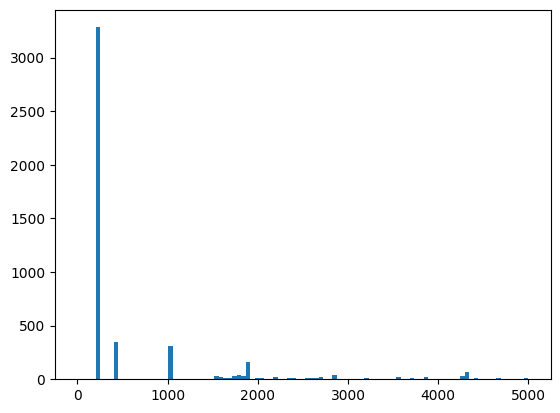

In [11]:
plt.hist(len_list, bins=np.linspace(0, 5000, 100));

# How many have lenght over 1000?
print(np.sum(np.array(len_list) > 1000))

# How many have length over 5000?
print(np.sum(np.array(len_list) > 5000))

In [12]:
transformer = Transformer(n_input=1)

x = jax.random.normal(jax.random.PRNGKey(0), (1, 200, 1))
init_rngs = {"params": jax.random.PRNGKey(0)}
out, params = transformer.init_with_output(init_rngs, x)

In [29]:
score_dict = {
            "d_model": 256,
            "d_mlp": 1024,
            "n_layers": 6,
            "n_heads": 4,
        }

vdm = VariationalDiffusionModel(d_feature=1, d_t_embedding=32, noise_scale=1e-4, noise_schedule="learned_linear")

init_rngs = {'params': jax.random.key(0), 'sample': jax.random.key(1)}
out, params = vdm.init_with_output(init_rngs, fluxes[:2, :, None], wavelengths[:2, :, None], masks[:2])

In [30]:
# Devices
num_local_devices = jax.local_device_count()
print(f"{num_local_devices} GPUs available")

4 GPUs available


In [31]:
# Define train state and replicate across devices

schedule = optax.warmup_cosine_decay_schedule(
    init_value=0.0,
    peak_value=3e-4,
    warmup_steps=500,
    decay_steps=3000,
)

tx = optax.adamw(learning_rate=schedule, weight_decay=1e-5)
state = TrainState.create(apply_fn=vdm.apply, params=params, tx=tx)
pstate = replicate(state)

In [34]:
def loss_vdm(outputs, masks=None):
    loss_diff, loss_klz, loss_recon = outputs
    if masks is None:
        masks = np.ones(x.shape[:-1])

    loss_batch = (((loss_diff + loss_klz) * masks[:, :, None]).sum((-1, -2)) + (loss_recon * masks[:, :, None]).sum((-1, -2))) / masks.sum(-1)
    return loss_batch.mean()

@partial(jax.pmap, axis_name="batch",)
def train_step(state, fluxes, wavelenghts, masks, key_sample):
    
    def loss_fn(params):
        outputs = state.apply_fn(params, fluxes, wavelenghts, masks, rngs={"sample": key_sample})
        loss = loss_vdm(outputs, masks)
        return loss

    # Get loss, grads, and update state
    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    grads = jax.lax.pmean(grads, "batch")
    new_state = state.apply_gradients(grads=grads)
    metrics = {"loss": jax.lax.pmean(loss, "batch")}
    
    return new_state, metrics

In [35]:
n_steps = 2000
n_batch = 32

key = jax.random.PRNGKey(0)

with trange(n_steps) as steps:
    for step in steps:
        key, *train_step_key = jax.random.split(key, num=jax.local_device_count() + 1)  # Split key across devices
        train_step_key = np.asarray(train_step_key)

        idx = jax.random.choice(key, fluxes.shape[0], shape=(n_batch,))

        fluxes_batch, wavelengths_batch, masks_batch = fluxes[idx], wavelengths[idx], masks[idx]

        # Split batches across devices
        fluxes_batch = jax.tree_map(lambda x: np.split(x, num_local_devices, axis=0), fluxes_batch)
        wavelengths_batch = jax.tree_map(lambda x: np.split(x, num_local_devices, axis=0), wavelengths_batch)
        masks_batch = jax.tree_map(lambda x: np.split(x, num_local_devices, axis=0), masks_batch)

        # Convert to np.ndarray
        fluxes_batch = np.array(fluxes_batch)
        wavelengths_batch = np.array(wavelengths_batch)
        masks_batch = np.array(masks_batch)
        
        pstate, metrics = train_step(pstate, fluxes_batch[..., None], wavelengths_batch[..., None], masks_batch, train_step_key)
        
        steps.set_postfix(loss=unreplicate(metrics["loss"]))

100%|██████████| 2000/2000 [01:04<00:00, 30.85it/s, loss=24.705055]


In [64]:
from models.diffusion_utils import generate

# Generate samples
n_samples = 24
wavelengths_cond = wavelengths[:1, : np.sum(masks[0])]
wavelengths_cond = np.linspace(np.min(wavelengths_cond), np.max(wavelengths_cond), 800)[None, ...]
samples = generate(vdm, unreplicate(pstate).params, jax.random.PRNGKey(942), (n_samples, len(wavelengths_cond[0])), wavelengths_cond[..., None], np.ones_like(wavelengths_cond), steps=200)

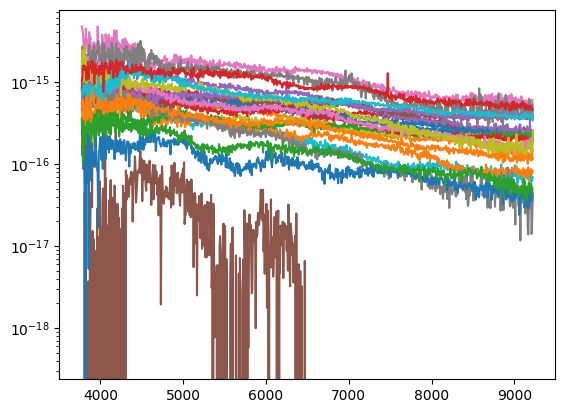

In [65]:
# Loop over all the samples
for i in range(n_samples):
    plt.plot(wavelengths_cond[0] * wavelengths_std + wavelengths_mean, samples.mean()[i, :, 0] * fluxes_std + fluxes_mean) # Generated sample

plt.yscale("log")

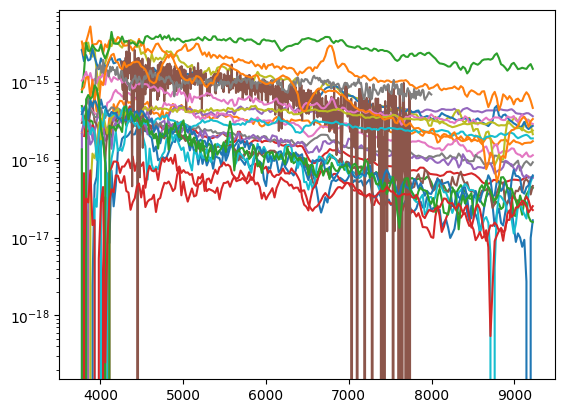

In [66]:
# Some training samples
for i in range(n_samples, n_samples + n_samples):
    wavelengths_unmaskes = wavelengths[i, masks[i]] * wavelengths_std + wavelengths_mean
    fluxes_unmasked = fluxes[i, masks[i]] * fluxes_std + fluxes_mean
    plt.plot(wavelengths_unmaskes, fluxes_unmasked) # Training sample

plt.yscale("log")